<a href="https://colab.research.google.com/github/ShFANI/ShFANI.github.io/blob/main/Demand_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demand Forecasting with Big Data (LightGBM, LSTM, and DeepAR)

End-to-end demand forecasting project on the Kaggle Store Item Demand Forecasting dataset.

## Dataset Overview

* A store chain's 5-year data includes information on 10 different stores and 50 different products.
* The data set covers the period between 01-01-2013 and 31-12-2017.

## Contents
1. Introduction
2. Importing Libraries
3. Load Dataset
4. Basic EDA
5. Feature Engineering (lags/rolling/EWM)
6. Data Encoding (one‑hot + log1p)
7. LightGBM Model (Original)
8. Time Series Analysis (Original, weekly)
9. LSTM Model (New)
10. DeepAR Model (New, PyTorch)
11. Model Comparison Dashboard
12. 3‑Month Sales Forecast + Plots


## 1) Introduction
### Business problem
Create a 3‑month demand forecasting model for 10 stores × 50 products using **LightGBM**, **LSTM**, and **DeepAR**. Compare models on **SMAPE**, **MAE**, and **RMSE**, then use the best model for the final forecast.

## Variables


*  date – Date of sales data
*  store – Store ID (1–10)
*  item – Item ID (1–50)
*  sales – Number of items sold









## 3) Load Dataset (desktop upload)
Upload `train.csv` and `test.csv` from the Kaggle competition. We will combine them and drop the `id` column.

In [1]:
# ── Standard Libraries ────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os, itertools

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)
np.random.seed(42)

# ── ML / Boosting ─────────────────────────────────────────────────────────────
!pip -q install -U lightgbm
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ── Traditional Time Series ───────────────────────────────────────────────────
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

# ── Deep Learning: LSTM via TensorFlow/Keras (stable) ─────────────────────────
# Fix JAX/ml_dtypes conflict by removing JAX + installing a stable TF build
!pip -q uninstall -y jax jaxlib
!pip -q install -U "ml_dtypes>=0.5" "tensorflow==2.15.0"

# IMPORTANT: after running installs, do Runtime -> Restart runtime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# ── Deep Learning: DeepAR via PyTorch ─────────────────────────────────────────
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

tf.random.set_seed(42)
torch.manual_seed(42)

print("TensorFlow:", tf.__version__)

ERROR: Could not find a version that satisfies the requirement tensorflow==2.15.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0, 2.21.0rc0)
ERROR: No matching distribution found for tensorflow==2.15.0
TensorFlow: 2.19.0


In [2]:
from google.colab import files
import io
import zipfile # Added import for zipfile handling

uploaded = files.upload()
print("Uploaded:", list(uploaded.keys()))

# Check if a zip file was uploaded
zip_filename = None
for k in uploaded.keys():
    if k.lower().endswith(".zip"):
        zip_filename = k
        break

if zip_filename:
    print(f"Detected zip file: {zip_filename}. Extracting contents...")
    # Extract the zip file
    with zipfile.ZipFile(io.BytesIO(uploaded[zip_filename]), 'r') as zf:
        # Get a list of names inside the zip file
        zip_contents = zf.namelist()

        train_csv_in_zip = next((name for name in zip_contents if "train" in name.lower() and name.lower().endswith(".csv")), None)
        test_csv_in_zip  = next((name for name in zip_contents if "test"  in name.lower() and name.lower().endswith(".csv")), None)

        if train_csv_in_zip is None:
            raise ValueError("Couldn't find 'train.csv' inside the uploaded zip file.")
        if test_csv_in_zip is None:
            raise ValueError("Couldn't find 'test.csv' inside the uploaded zip file.")

        # Read CSVs directly from the zip file's contents
        train = pd.read_csv(zf.open(train_csv_in_zip), parse_dates=["date"])
        test  = pd.read_csv(zf.open(test_csv_in_zip),  parse_dates=["date"])
        print(f"Found 'train.csv' and 'test.csv' inside {zip_filename}.")
else:
    # Original logic for direct CSV upload
    train_name = next((k for k in uploaded.keys() if k.lower().endswith(".csv") and "train" in k.lower()), None)
    test_name  = next((k for k in uploaded.keys() if k.lower().endswith(".csv") and "test"  in k.lower()), None)

    if train_name is None: raise ValueError("Couldn't find train CSV. Upload a file with 'train' in its name.")
    if test_name  is None: raise ValueError("Couldn't find test CSV. Upload a file with 'test' in its name.")

    train = pd.read_csv(io.BytesIO(uploaded[train_name]), parse_dates=["date"])
    test  = pd.read_csv(io.BytesIO(uploaded[test_name]),  parse_dates=["date"])
    print("Found direct CSV uploads.")

df = pd.concat([train, test], sort=False)
print("Size of train set:", train.shape)
print("Size of test set :", test.shape)

# Remove optional id column if present
if "id" in df.columns:
    df.drop(["id"], axis=1, inplace=True)

df = df.sort_values(["store","item","date"]).reset_index(drop=True)
df.head()

Saving demand-forecasting-kernels-only.zip to demand-forecasting-kernels-only.zip
Uploaded: ['demand-forecasting-kernels-only.zip']
Detected zip file: demand-forecasting-kernels-only.zip. Extracting contents...
Found 'train.csv' and 'test.csv' inside demand-forecasting-kernels-only.zip.
Size of train set: (913000, 4)
Size of test set : (45000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13.0
1,2013-01-02,1,1,11.0
2,2013-01-03,1,1,14.0
3,2013-01-04,1,1,13.0
4,2013-01-05,1,1,10.0


## 4) Basic Exploratory Data Analysis
We do key checks: date range, sales distribution, store/item counts, and a few plots.

Date range: 2013-01-01 00:00:00 to 2018-03-31 00:00:00
count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
10%          20.000000
30%          33.000000
50%          47.000000
70%          64.000000
80%          76.000000
90%          93.000000
95%         107.000000
99%         135.000000
max         231.000000
Name: sales, dtype: float64
Number of stores  : 10
Number of products: 50
store
1    50
2    50
3    50
4    50
5    50
Name: item, dtype: int64


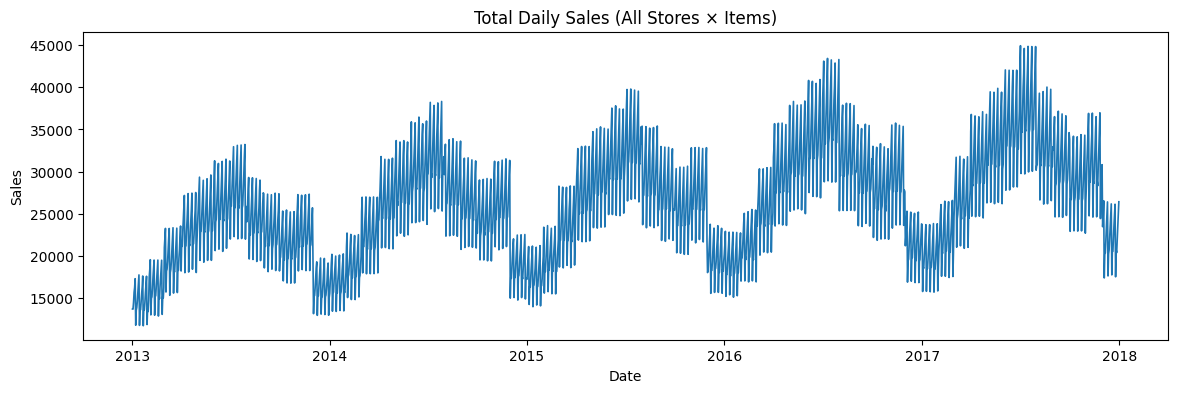

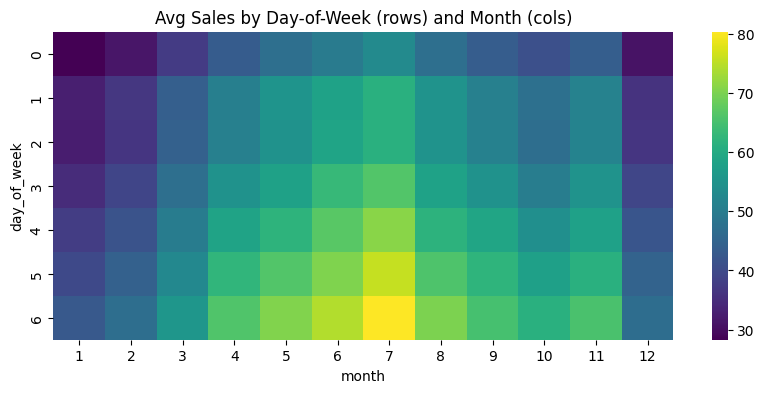

In [3]:

print("Date range:", df["date"].min(), "to", df["date"].max())

# Sales distribution (train only; test has NaNs in sales)
train_only = df[~df["sales"].isna()].copy()
print(train_only["sales"].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99]))

print("Number of stores  :", train_only["store"].nunique())
print("Number of products:", train_only["item"].nunique())

# Every store sells all products?
print(train_only.groupby("store")["item"].nunique().head())

# Plot: total daily sales
daily_sales = (train_only.groupby("date")["sales"].sum().reset_index())
plt.figure(figsize=(14,4))
plt.plot(daily_sales["date"], daily_sales["sales"], linewidth=1.2)
plt.title("Total Daily Sales (All Stores × Items)")
plt.xlabel("Date"); plt.ylabel("Sales")
plt.show()

# Heat-ish view: avg sales by month and day of week
tmp = train_only.copy()
tmp["month"] = tmp["date"].dt.month
tmp["day_of_week"] = tmp["date"].dt.dayofweek
pivot = tmp.pivot_table(index="day_of_week", columns="month", values="sales", aggfunc="mean")
plt.figure(figsize=(10,4))
sns.heatmap(pivot, cmap="viridis")
plt.title("Avg Sales by Day-of-Week (rows) and Month (cols)")
plt.show()


In [4]:
# Sales statistics in store-product breakdown
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})


sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

## 5) Feature Engineering
This section we create the calendar features, random noise, lag features, triangular rolling means, and EWM features.

In [5]:

# Calendar features
df["month"]          = df.date.dt.month
df["day_of_month"]   = df.date.dt.day
df["day_of_year"]    = df.date.dt.dayofyear
df["week_of_year"]   = df.date.dt.isocalendar().week.astype(int)
df["day_of_week"]    = df.date.dt.dayofweek
df["year"]           = df.date.dt.year
df["is_wknd"]        = df.date.dt.weekday // 4
df["is_month_start"] = df.date.dt.is_month_start.astype(int)
df["is_month_end"]   = df.date.dt.is_month_end.astype(int)

def random_noise(dataframe, scale=1.6):
    return np.random.normal(scale=scale, size=(len(dataframe),))

# Lag/Shifted Features (store×item)
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe[f"sales_lag_{lag}"] = (
            dataframe.groupby(["store","item"])["sales"]
            .transform(lambda x: x.shift(lag))
        ) + random_noise(dataframe)
    return dataframe

df = df.sort_values(["store","item","date"]).reset_index(drop=True)
df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

# Moving Average Features (triangular window)
def moving_average_features(dataframe, windows):
    for window in windows:
        dataframe[f"sales_roll_mean_{window}"] = (
            dataframe.groupby(["store","item"])["sales"]
            .transform(lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean())
        ) + random_noise(dataframe)
    return dataframe

df = moving_average_features(df, [365, 546, 730])

# Exponentially Weighted Average Features
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            col = f"sales_ewm_alpha_{str(alpha).replace('.','')}_lag_{lag}"
            dataframe[col] = dataframe.groupby(["store","item"])["sales"].transform(
                lambda x: x.shift(lag).ewm(alpha=alpha).mean()
            )
    return dataframe

alphas = [0.99, 0.95, 0.9, 0.8, 0.7, 0.5]
lags   = [91, 98, 105, 112, 180, 270, 365, 546, 728]
df = ewm_features(df, alphas, lags)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958000 entries, 0 to 957999
Data columns (total 80 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   date                         958000 non-null  datetime64[ns]
 1   store                        958000 non-null  int64         
 2   item                         958000 non-null  int64         
 3   sales                        913000 non-null  float64       
 4   month                        958000 non-null  int32         
 5   day_of_month                 958000 non-null  int32         
 6   day_of_year                  958000 non-null  int32         
 7   week_of_year                 958000 non-null  int64         
 8   day_of_week                  958000 non-null  int32         
 9   year                         958000 non-null  int32         
 10  is_wknd                      958000 non-null  int32         
 11  is_month_start            

## 6) Data Encoding
One-hot encode `day_of_week` and `month`, then apply `log1p` to `sales`.

In [6]:

# One-hot encoding
df = pd.get_dummies(df, columns=["day_of_week", "month"], drop_first=False)

# Log transform sales (keep NaNs in test)
df.loc[~df["sales"].isna(), "sales"] = np.log1p(df.loc[~df["sales"].isna(), "sales"].values)

df.head()


,date,store,item,sales,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_730,sales_ewm_alpha_099_lag_91,sales_ewm_alpha_099_lag_98,sales_ewm_alpha_099_lag_105,sales_ewm_alpha_099_lag_112,sales_ewm_alpha_099_lag_180,sales_ewm_alpha_099_lag_270,sales_ewm_alpha_099_lag_365,sales_ewm_alpha_099_lag_546,sales_ewm_alpha_099_lag_728,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2013-01-01,1,1,2.639057,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,2013-01-02,1,1,2.484907,2,2,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
2,2013-01-03,1,1,2.708050,3,3,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,2013-01-04,1,1,2.639057,4,4,1,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False
4,2013-01-05,1,1,2.397895,5,5,1,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,True,F

## 7) LightGBM Model (Original)
Split: train < 2017-01-01, validation = first 3 months of 2017. Use custom SMAPE and LightGBM training with early stopping.

In [7]:

import numpy as np
import lightgbm as lgb

# -------------------------
# 1) Train/validation split
# -------------------------
# Train data set until the beginning of 2017 (end of 2016)
train_lgb = df.loc[(df["date"] < "2017-01-01") & (~df["sales"].isna()), :].copy()
# First 3 months of 2017 as validation set
val_lgb   = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01") & (~df["sales"].isna()), :].copy()

# Columns (drop date/target and any leakage-like columns)
drop_cols = ["date", "sales", "year"]
cols = [c for c in train_lgb.columns if c not in drop_cols]

X_train = train_lgb[cols]
y_train = train_lgb["sales"].values  # log1p scale
X_val   = val_lgb[cols]
y_val   = val_lgb["sales"].values    # log1p scale

print("Shapes:", X_train.shape, X_val.shape)

# ----------------------------------------
# 2) Cast numeric columns to float32 (FAST)
# ----------------------------------------
# This alone often cuts runtime substantially.
X_train = X_train.astype(np.float32)
X_val   = X_val.astype(np.float32)

# --- FIX: Ensure unique column names for LightGBM ---
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_val   = X_val.loc[:, ~X_val.columns.duplicated()]
# ---------------------------------------------------

# -------------------------
# 3) Custom SMAPE (raw scale)
# -------------------------
def smape_raw(y_true_raw, y_pred_raw):
    y_true_raw = np.asarray(y_true_raw, dtype=np.float64)
    y_pred_raw = np.asarray(y_pred_raw, dtype=np.float64)
    denom = (np.abs(y_true_raw) + np.abs(y_pred_raw))
    denom = np.where(denom == 0, 1.0, denom)
    return 200.0 * np.mean(np.abs(y_true_raw - y_pred_raw) / denom)

def smape_feval(y_pred, dataset):
    # y_pred and dataset labels are in log1p scale → convert back
    y_true = dataset.get_label()
    y_true_raw = np.expm1(y_true)
    y_pred_raw = np.expm1(y_pred)
    return "SMAPE", smape_raw(y_true_raw, y_pred_raw), False

# ----------------------------------------------------
# 4) LightGBM datasets (set max_bin for speed, too)
# ----------------------------------------------------
lgbtrain = lgb.Dataset(X_train, label=y_train, free_raw_data=True)
lgbval   = lgb.Dataset(X_val, label=y_val, reference=lgbtrain, free_raw_data=True)

# ---------------------------------------
# 5) Faster params (big speed improvements)
# ---------------------------------------
params = {
    "objective": "regression",
    "metric": "mae",            # keep a built-in metric; SMAPE via feval
    "learning_rate": 0.05,      # slightly higher LR → fewer rounds
    "num_leaves": 64,
    "max_depth": -1,
    "min_data_in_leaf": 200,    # regularize + speed
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "lambda_l2": 1.0,
    "max_bin": 255,             # smaller bins can speed up
    "force_col_wise": True,     # often faster in wide data
    "verbosity": -1,
    "num_threads": 8            # Colab usually benefits from 8
}

# -------------------------
# 6) Train (reduced cap)
# -------------------------
# 10,000 with 200 early-stop can still be slow when features are huge.
# This usually converges well under 2,000–3,000 rounds with LR=0.05.
model = lgb.train(
    params,
    lgbtrain,
    num_boost_round=3000,
    valid_sets=[lgbval],
    feval=smape_feval,
    callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
)

# -------------------------
# 7) Evaluate SMAPE on val
# -------------------------
pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape_score = smape_raw(np.expm1(y_val), np.expm1(pred_val))
print(f"Best iteration: {model.best_iteration}")
print(f"LightGBM Validation SMAPE: {smape_score:.4f}")


Shapes: (730500, 94) (45000, 94)
Best iteration: 1146
LightGBM Validation SMAPE: 13.5708


### Final LightGBM model on all training data + predict test
Train on all non-missing `sales`, predict for test rows (where sales is NaN).

In [8]:

train_all = df.loc[~df["sales"].isna(), :].copy()
test_df   = df.loc[df["sales"].isna(), :].copy()

Y_train_all = train_all["sales"]

# The 'cols' variable from the previous cell is used here, but it might contain duplicate names
# and its length might not match the actual number of unique features LightGBM uses.
# We need to ensure X_train_all and X_test have unique columns names.
# Create these DataFrames by selecting columns from `cols` and then deduplicate.
X_train_all = train_all[cols].loc[:, ~train_all[cols].columns.duplicated()]
X_test      = test_df[cols].loc[:, ~test_df[cols].columns.duplicated()]

# Now, create the `feature_name` list from the unique columns of X_train_all.
# This list will have the correct length (151, as inferred by LightGBM).
final_feature_names = X_train_all.columns.tolist()

# Cast to float32 for consistency and speed
X_train_all = X_train_all.astype(np.float32)
X_test      = X_test.astype(np.float32)

lgbtrain_all = lgb.Dataset(X_train_all, label=Y_train_all, feature_name=final_feature_names)

lgbm_final = lgb.train(
    {**params},
    lgbtrain_all,
    num_boost_round=model.best_iteration
)

lgbm_test_preds = lgbm_final.predict(X_test, num_iteration=lgbm_final.best_iteration)
print("LightGBM final model trained successfully.")

# Convert to original scale for forecasts
lgbm_test_preds_raw = np.expm1(lgbm_test_preds)

# Build daily total forecast (sum across store×item per date)
lgbm_daily_forecast = (
    test_df[["date"]].copy()
    .assign(pred=lgbm_test_preds_raw)
    .groupby("date")["pred"].sum().reset_index()
    .rename(columns={"pred":"total_sales"})
)
lgbm_daily_forecast.head()


LightGBM final model trained successfully.


,date,total_sales
0,2018-01-01,16631.594183
1,2018-01-02,19440.155336
2,2018-01-03,19474.981624
3,2018-01-04,20875.617611
4,2018-01-05,22238.434288


## 8) Time Series Analysis (Original) — Weekly
The original notebook resamples to weekly mean and runs a similar feature pipeline plus LightGBM.

In [9]:

# Reload train raw (from already uploaded train)
data = train.copy()
data = data.sort_values("date")
data = data.set_index("date")

df_weekly = data.resample("W").mean(numeric_only=True).reset_index()
print("Weekly data shape:", df_weekly.shape)
df_weekly.head()


Weekly data shape: (261, 4)


,date,store,item,sales
0,2013-01-06,5.5,25.5,30.355667
1,2013-01-13,5.5,25.5,29.686286
2,2013-01-20,5.5,25.5,29.414286
3,2013-01-27,5.5,25.5,29.513714
4,2013-02-03,5.5,25.5,31.150571


In [11]:
import numpy as np
import pandas as pd
import lightgbm as lgb

# ----------------------------
# 0) Start from raw train data
# ----------------------------
data = train.copy()  # assumes train has columns: date, store, item, sales
data["date"] = pd.to_datetime(data["date"])
data = data.sort_values("date").set_index("date")

# ----------------------------
# 1) Weekly aggregation
# ----------------------------
# Mean sales per week across all store×item rows (mirrors many "weekly TS" demos)
df_weekly = data.resample("W").mean(numeric_only=True).reset_index()
df_weekly = df_weekly.rename(columns={"index": "date"}) if "index" in df_weekly.columns else df_weekly
print("Weekly shape:", df_weekly.shape)
display(df_weekly.head())

# ----------------------------
# 2) Helper: random noise (optional)
# ----------------------------
def random_noise(n, scale=1.6, seed=42):
    rng = np.random.default_rng(seed)
    return rng.normal(scale=scale, size=n)

# ----------------------------
# 3) Feature engineering (weekly)
# ----------------------------
df_weekly["month"]          = df_weekly["date"].dt.month
df_weekly["day_of_month"]   = df_weekly["date"].dt.day
df_weekly["day_of_year"]    = df_weekly["date"].dt.dayofyear
df_weekly["week_of_year"]   = df_weekly["date"].dt.isocalendar().week.astype(int)
df_weekly["day_of_week"]    = df_weekly["date"].dt.dayofweek
df_weekly["year"]           = df_weekly["date"].dt.year
df_weekly["is_wknd"]        = (df_weekly["date"].dt.weekday // 4).astype(int)
df_weekly["is_month_start"] = df_weekly["date"].dt.is_month_start.astype(int)
df_weekly["is_month_end"]   = df_weekly["date"].dt.is_month_end.astype(int)

# Lags
lags = [31, 61, 91, 98, 105, 112]
for lag in lags:
    df_weekly[f"sales_lag_{lag}"] = df_weekly["sales"].shift(lag)

# Rolling means (triangular requires enough points; if it errors, switch to simple rolling mean)
windows = [31, 61, 91, 98, 105, 112]
for w in windows:
    try:
        df_weekly[f"sales_roll_mean_{w}"] = (
            df_weekly["sales"].shift(1).rolling(window=w, min_periods=10, win_type="triang").mean()
        )
    except Exception:
        # fallback: simple rolling mean
        df_weekly[f"sales_roll_mean_{w}"] = (
            df_weekly["sales"].shift(1).rolling(window=w, min_periods=10).mean()
        )

# EWMs
alphas = [0.99, 0.95, 0.9, 0.8, 0.7, 0.5]
ewm_lags = [10, 20, 30, 40, 50]
for a in alphas:
    for lag in ewm_lags:
        df_weekly[f"sales_ewm_alpha_{str(a).replace('.','')}_lag_{lag}"] = (
            df_weekly["sales"].shift(lag).ewm(alpha=a).mean()
        )

# Drop early rows with NA from lags/rolling
df_weekly = df_weekly.dropna().reset_index(drop=True)

# ----------------------------
# 4) Encoding + target transform
# ----------------------------
df_weekly = pd.get_dummies(df_weekly, columns=["day_of_week", "month"], drop_first=False)

# log1p target (as in your daily model)
df_weekly["sales"] = np.log1p(df_weekly["sales"].values)

# ----------------------------
# 5) Train/test split (weekly)
# ----------------------------
train_w = df_weekly[df_weekly["date"] < "2017-01-01"].copy()
test_w  = df_weekly[df_weekly["date"] >= "2017-01-01"].copy()

# Build feature list AFTER encoding (this fixes your mismatch)
cols_w = [c for c in train_w.columns if c not in ["date", "sales", "year"]]

X_train_w = train_w[cols_w]
y_train_w = train_w["sales"]
X_test_w  = test_w[cols_w].reindex(columns=cols_w, fill_value=0)  # align columns
y_test_w  = test_w["sales"]

print("X_train_w:", X_train_w.shape, "X_test_w:", X_test_w.shape, "len(cols_w):", len(cols_w))

# ----------------------------
# 6) Custom SMAPE on raw scale
# ----------------------------
def smape_np(y_true_raw, y_pred_raw):
    y_true_raw = np.array(y_true_raw, float)
    y_pred_raw = np.array(y_pred_raw, float)
    denom = np.abs(y_true_raw) + np.abs(y_pred_raw)
    denom = np.where(denom == 0, 1.0, denom)
    return 200.0 * np.mean(np.abs(y_true_raw - y_pred_raw) / denom)

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    return "SMAPE", smape_np(np.expm1(labels), np.expm1(preds)), False

# ----------------------------
# 7) Train LightGBM (weekly)
# ----------------------------
lgb_params = {
    "objective": "regression",
    "metric": "mae",
    "num_leaves": 64,
    "learning_rate": 0.05,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "min_data_in_leaf": 5, # Changed from 50 to 5
    "max_depth": -1,
    "verbosity": -1,
    "num_threads": 8
}

lgbtrain_w = lgb.Dataset(X_train_w, label=y_train_w)          # no feature_name (safe)
lgbval_w   = lgb.Dataset(X_test_w,  label=y_test_w, reference=lgbtrain_w)

model_w = lgb.train(
    lgb_params,
    lgbtrain_w,
    valid_sets=[lgbval_w],
    num_boost_round=3000,
    feval=lgbm_smape,
    callbacks=[lgb.early_stopping(100, verbose=False)]
)

# ----------------------------
# 8) Evaluate
# ----------------------------
pred_w = model_w.predict(X_test_w, num_iteration=model_w.best_iteration)
weekly_smape = smape_np(np.expm1(y_test_w.values), np.expm1(pred_w))

print(f"Weekly LightGBM — Best iteration: {model_w.best_iteration}")
print(f"Weekly LightGBM — Validation SMAPE: {weekly_smape:.4f}")

Weekly shape: (261, 4)


,date,store,item,sales
0,2013-01-06,5.5,25.5,30.355667
1,2013-01-13,5.5,25.5,29.686286
2,2013-01-20,5.5,25.5,29.414286
3,2013-01-27,5.5,25.5,29.513714
4,2013-02-03,5.5,25.5,31.150571


X_train_w: (96, 63) X_test_w: (53, 63) len(cols_w): 63
Weekly LightGBM — Best iteration: 124
Weekly LightGBM — Validation SMAPE: 2.8165


                       feature  split       gain
12               sales_lag_105    201  64.662951
49   sales_ewm_alpha_05_lag_50     77  19.480582
47   sales_ewm_alpha_05_lag_30     31   3.777716
44   sales_ewm_alpha_07_lag_50     17   1.807763
39   sales_ewm_alpha_08_lag_50     30   1.682852
22  sales_ewm_alpha_099_lag_30     48   1.466494
10                sales_lag_91     88   0.798888
57                     month_7     24   0.798206
8                 sales_lag_31     54   0.645203
24  sales_ewm_alpha_099_lag_50     53   0.580478
9                 sales_lag_61     69   0.452734
13               sales_lag_112     57   0.408667
2                 day_of_month    160   0.381021
14          sales_roll_mean_31     28   0.364432
16          sales_roll_mean_91     24   0.358086
42   sales_ewm_alpha_07_lag_30     11   0.291579
37   sales_ewm_alpha_08_lag_30      8   0.205469
3                  day_of_year     48   0.190246
15          sales_roll_mean_61     50   0.187671
23  sales_ewm_alpha_

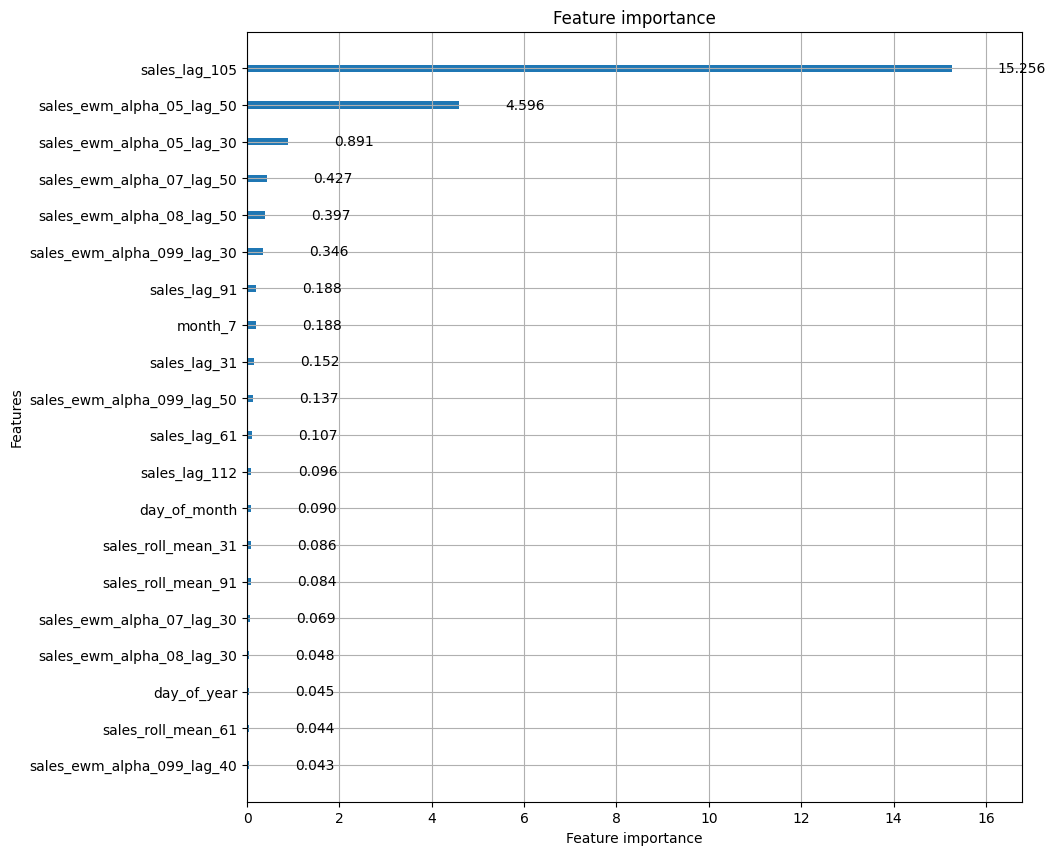

In [12]:
# Feature Importance
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({
        'feature': model.feature_name(),
        'split': model.feature_importance('split'),
        'gain': 100 * gain / gain.sum()
    }).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('Feature Importance (Gain)')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))

plot_lgb_importances(model_w, num=30)
lgb.plot_importance(model_w, max_num_features=20, figsize=(10, 10), importance_type="gain")
plt.show()

## 9) LSTM Model (New)
We forecast **total daily sales** with a **Bidirectional LSTM** and rolls out 90 days recursively, then compares models.

Input (window × 1)
  → Bidirectional LSTM(128, return_sequences=True) + BatchNorm + Dropout(0.2)
  → Bidirectional LSTM(64,  return_sequences=False) + BatchNorm + Dropout(0.2)
  → Dense(32, relu)
  → Dense(1)           ← single-step output (rolled over forecast horizon)

In [13]:
# ── 9.1  Prepare the daily aggregated series ──────────────────────────────────

# Read CSVs directly from the zip file's contents
train_raw_lstm = train

# Aggregate total daily sales across all stores and all items
daily_sales = (
    train_raw_lstm
    .groupby('date')['sales']
    .sum()
    .reset_index()
    .sort_values('date')
)

print(f"Daily series length : {len(daily_sales)} days")
print(f"Date range          : {daily_sales.date.min().date()} → {daily_sales.date.max().date()}")
daily_sales.head()

Daily series length : 1826 days
Date range          : 2013-01-01 → 2017-12-31


,date,sales
0,2013-01-01,13696
1,2013-01-02,13678
2,2013-01-03,14488
3,2013-01-04,15677
4,2013-01-05,16237


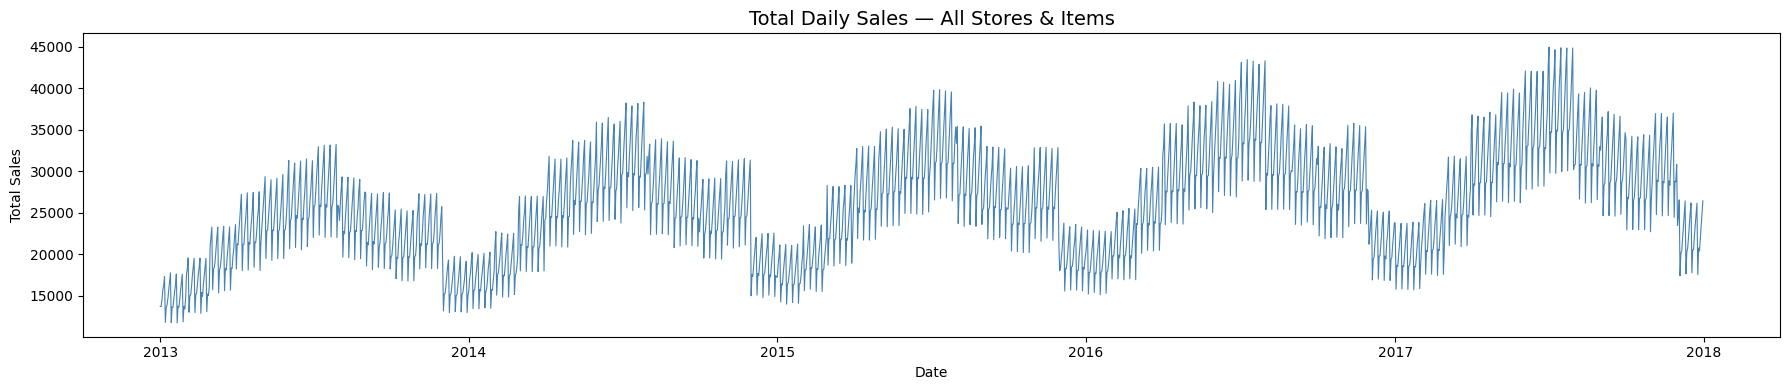

In [14]:
# ── 9.2  Visualise the series ─────────────────────────────────────────────────
plt.figure(figsize=(18, 4))
plt.plot(daily_sales['date'], daily_sales['sales'], linewidth=0.8, color='steelblue')
plt.title('Total Daily Sales — All Stores & Items', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

In [15]:
# ── 9.3  Scale and create sliding-window sequences ────────────────────────────
LSTM_WINDOW   = 90   # look-back window (days)
LSTM_HORIZON  = 90   # forecast horizon (3 months)
LSTM_EPOCHS   = 60
LSTM_BATCH    = 32

scaler_lstm = MinMaxScaler(feature_range=(0, 1))
sales_scaled = scaler_lstm.fit_transform(daily_sales[['sales']]).flatten()

def create_sequences(data, window):
    """
    Convert a 1-D time series into (X, y) sliding-window pairs.
    X shape: (n_samples, window, 1)
    y shape: (n_samples,)
    """
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i : i + window])
        y.append(data[i + window])
    return np.array(X).reshape(-1, window, 1), np.array(y)

X_seq, y_seq = create_sequences(sales_scaled, LSTM_WINDOW)

# Train / validation split — hold out last 90 days for validation
split_idx = len(X_seq) - LSTM_HORIZON
X_lstm_train, X_lstm_val = X_seq[:split_idx], X_seq[split_idx:]
y_lstm_train, y_lstm_val = y_seq[:split_idx], y_seq[split_idx:]

print(f"X_train : {X_lstm_train.shape}  |  y_train : {y_lstm_train.shape}")
print(f"X_val   : {X_lstm_val.shape}  |  y_val   : {y_lstm_val.shape}")


X_train : (1646, 90, 1)  |  y_train : (1646,)
X_val   : (90, 90, 1)  |  y_val   : (90,)


In [16]:
# ── 9.4  Build the Bidirectional LSTM model ───────────────────────────────────
def build_lstm_model(window_size):
    """
    Bidirectional LSTM with BatchNorm and Dropout for robust time-series forecasting.
    """
    model = Sequential([
        # ── Layer 1: Bidirectional LSTM returns full sequence ─────────────────
        Bidirectional(
            LSTM(128, return_sequences=True),
            input_shape=(window_size, 1)
        ),
        BatchNormalization(),
        Dropout(0.2),

        # ── Layer 2: Bidirectional LSTM returns last hidden state ─────────────
        Bidirectional(LSTM(64, return_sequences=False)),
        BatchNormalization(),
        Dropout(0.2),

        # ── Fully connected head ──────────────────────────────────────────────
        Dense(32, activation='relu'),
        Dense(1)   # single-step prediction
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='huber',          # robust to outliers vs pure MSE
        metrics=['mae']
    )
    return model

lstm_model = build_lstm_model(LSTM_WINDOW)
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 90, 256)        │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 90, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 303,169 (1.16 MB)

 Trainable params: 302,401 (1.15 MB)

 Non-trainable params: 768 (3.00 KB)

In [17]:
# ── 9.5  Callbacks ────────────────────────────────────────────────────────────
callbacks_lstm = [
    EarlyStopping(
        monitor='val_loss', patience=10,
        restore_best_weights=True, verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss', factor=0.5,
        patience=5, min_lr=1e-6, verbose=1
    ),
    ModelCheckpoint(
        'best_lstm.h5', monitor='val_loss',
        save_best_only=True, verbose=0
    )
]

In [18]:
# ── 9.6  Train the LSTM ───────────────────────────────────────────────────────
!pip -q uninstall -y tensorflow tensorflow-cpu tf-keras keras
!pip -q install --no-cache-dir --force-reinstall "numpy<2.0" "ml_dtypes>=0.5"
!pip -q install --no-cache-dir --force-reinstall "tensorflow==2.19.0"

import tensorflow as tf, numpy as np
print("TF:", tf.__version__, "numpy:", np.__version__)

# quick sanity check
ds = tf.data.Dataset.range(5)
print(list(ds.as_numpy_iterator()))
history_lstm = lstm_model.fit(
    X_lstm_train, y_lstm_train,
    validation_data=(X_lstm_val, y_lstm_val),
    epochs=LSTM_EPOCHS,
    batch_size=LSTM_BATCH,
    callbacks=callbacks_lstm,
    verbose=1
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 203.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 261.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-hub 0.16.1 requires tf-keras>=2.14.1, which is not installed.
keras-hub 0.21.1 requires keras>=3.5, which is not installed.
orbax-checkpoint 0.11.32 requires jax>=0.6.0, which is not installed.
flax 0.11.2 requires jax>=0.6.0, which is not installed.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, which is not installed.
tensorflow-decision-forests 1.12.0 requires tf_keras~=2.19, which is not installed.
optax 0.2.7 requires jax>=0.5.3, which is not installed.
optax 0.2.7 requires jaxlib>=0.5.3, which is not installed.
dopamine-rl 4.1.2 requires jax>=0.1.

52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 411ms/step - loss: 0.2860 - mae: 0.6153 - val_loss: 0.1463 - val_mae: 0.5205 - learning_rate: 0.0010
Epoch 2/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 371ms/step - loss: 0.1020 - mae: 0.3560 - val_loss: 0.1530 - val_mae: 0.5349 - learning_rate: 0.0010
Epoch 3/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 404ms/step - loss: 0.0585 - mae: 0.2691 - val_loss: 0.1703 - val_mae: 0.5696 - learning_rate: 0.0010
Epoch 4/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - loss: 0.0444 - mae: 0.2391

52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 373ms/step - loss: 0.0444 - mae: 0.2390 - val_loss: 0.1338 - val_mae: 0.5017 - learning_rate: 0.0010
Epoch 5/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - loss: 0.0378 - mae: 0.2193

52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 405ms/step - loss: 0.0378 - mae: 0.2192 - val_loss: 0.1220 - val_mae: 0.4737 - learning_rate: 0.0010
Epoch 6/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 373ms/step - loss: 0.0268 - mae: 0.1848 - val_loss: 0.1605 - val_mae: 0.5517 - learning_rate: 0.0010
Epoch 7/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 404ms/step - loss: 0.0228 - mae: 0.1706 - val_loss: 0.1261 - val_mae: 0.4818 - learning_rate: 0.0010
Epoch 8/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - loss: 0.0216 - mae: 0.1643

52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 380ms/step - loss: 0.0216 - mae: 0.1643 - val_loss: 0.0506 - val_mae: 0.2879 - learning_rate: 0.0010
Epoch 9/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - loss: 0.0190 - mae: 0.1521

52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 390ms/step - loss: 0.0189 - mae: 0.1521 - val_loss: 0.0429 - val_mae: 0.2647 - learning_rate: 0.0010
Epoch 10/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - loss: 0.0162 - mae: 0.1422

52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 388ms/step - loss: 0.0162 - mae: 0.1423 - val_loss: 0.0256 - val_mae: 0.1948 - learning_rate: 0.0010
Epoch 11/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - loss: 0.0137 - mae: 0.1296

52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 387ms/step - loss: 0.0137 - mae: 0.1297 - val_loss: 0.0169 - val_mae: 0.1500 - learning_rate: 0.0010
Epoch 12/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - loss: 0.0137 - mae: 0.1309

52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 402ms/step - loss: 0.0137 - mae: 0.1309 - val_loss: 0.0075 - val_mae: 0.1005 - learning_rate: 0.0010
Epoch 13/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 372ms/step - loss: 0.0119 - mae: 0.1213 - val_loss: 0.0118 - val_mae: 0.1320 - learning_rate: 0.0010
Epoch 14/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 406ms/step - loss: 0.0110 - mae: 0.1165 - val_loss: 0.0107 - val_mae: 0.1237 - learning_rate: 0.0010
Epoch 15/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 372ms/step - loss: 0.0113 - mae: 0.1205 - val_loss: 0.0086 - val_mae: 0.1099 - learning_rate: 0.0010
Epoch 16/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 402ms/step - loss: 0.0096 - mae: 0.1086 - val_loss: 0.0085 - val_mae: 0.1087 - learning_rate: 0.0010
Epoch 17/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - loss: 0.0093 - mae: 0.1078
Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 372ms/step - loss: 0.0093 - mae: 0.1079 - val_loss: 0.0086 - val_mae: 0.1103 - learning_rate: 0.0010
E

52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 405ms/step - loss: 0.0092 - mae: 0.1073 - val_loss: 0.0072 - val_mae: 0.0974 - learning_rate: 5.0000e-04
Epoch 19/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 40s 385ms/step - loss: 0.0085 - mae: 0.1022 - val_loss: 0.0076 - val_mae: 0.0988 - learning_rate: 5.0000e-04
Epoch 20/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 393ms/step - loss: 0.0081 - mae: 0.0994 - val_loss: 0.0088 - val_mae: 0.1114 - learning_rate: 5.0000e-04
Epoch 21/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 377ms/step - loss: 0.0078 - mae: 0.0984 - val_loss: 0.0081 - val_mae: 0.1053 - learning_rate: 5.0000e-04
Epoch 22/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 401ms/step - loss: 0.0083 - mae: 0.1015 - val_loss: 0.0078 - val_mae: 0.1032 - learning_rate: 5.0000e-04
Epoch 23/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - loss: 0.0080 - mae: 0.1005
Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 400ms/step - loss: 0.0080 - mae: 0.1005 - val_loss: 0.0079 - val_mae: 0.1038 - lea

52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 372ms/step - loss: 0.0074 - mae: 0.0936 - val_loss: 0.0067 - val_mae: 0.0928 - learning_rate: 2.5000e-04
Epoch 25/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - loss: 0.0074 - mae: 0.0943

52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 404ms/step - loss: 0.0074 - mae: 0.0943 - val_loss: 0.0066 - val_mae: 0.0924 - learning_rate: 2.5000e-04
Epoch 26/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - loss: 0.0070 - mae: 0.0936

52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 372ms/step - loss: 0.0070 - mae: 0.0936 - val_loss: 0.0065 - val_mae: 0.0906 - learning_rate: 2.5000e-04
Epoch 27/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - loss: 0.0067 - mae: 0.0904

52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 393ms/step - loss: 0.0067 - mae: 0.0905 - val_loss: 0.0064 - val_mae: 0.0886 - learning_rate: 2.5000e-04
Epoch 28/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 383ms/step - loss: 0.0074 - mae: 0.0926 - val_loss: 0.0064 - val_mae: 0.0904 - learning_rate: 2.5000e-04
Epoch 29/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - loss: 0.0066 - mae: 0.0884

52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 373ms/step - loss: 0.0066 - mae: 0.0885 - val_loss: 0.0062 - val_mae: 0.0896 - learning_rate: 2.5000e-04
Epoch 30/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - loss: 0.0066 - mae: 0.0888

52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 398ms/step - loss: 0.0066 - mae: 0.0889 - val_loss: 0.0061 - val_mae: 0.0869 - learning_rate: 2.5000e-04
Epoch 31/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 401ms/step - loss: 0.0064 - mae: 0.0885 - val_loss: 0.0062 - val_mae: 0.0894 - learning_rate: 2.5000e-04
Epoch 32/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 374ms/step - loss: 0.0067 - mae: 0.0892 - val_loss: 0.0063 - val_mae: 0.0874 - learning_rate: 2.5000e-04
Epoch 33/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - loss: 0.0063 - mae: 0.0863

52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 399ms/step - loss: 0.0063 - mae: 0.0864 - val_loss: 0.0058 - val_mae: 0.0822 - learning_rate: 2.5000e-04
Epoch 34/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 39s 372ms/step - loss: 0.0065 - mae: 0.0893 - val_loss: 0.0059 - val_mae: 0.0830 - learning_rate: 2.5000e-04
Epoch 35/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 399ms/step - loss: 0.0061 - mae: 0.0868 - val_loss: 0.0061 - val_mae: 0.0845 - learning_rate: 2.5000e-04
Epoch 36/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 371ms/step - loss: 0.0063 - mae: 0.0872 - val_loss: 0.0065 - val_mae: 0.0894 - learning_rate: 2.5000e-04
Epoch 37/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 404ms/step - loss: 0.0061 - mae: 0.0862 - val_loss: 0.0068 - val_mae: 0.0928 - learning_rate: 2.5000e-04
Epoch 38/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - loss: 0.0061 - mae: 0.0865
Epoch 38: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 372ms/step - loss: 0.0061 - mae: 0.0866 - val_loss: 0.0058 - val_mae: 0.0782 - lea

52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 404ms/step - loss: 0.0056 - mae: 0.0818 - val_loss: 0.0057 - val_mae: 0.0841 - learning_rate: 1.2500e-04
Epoch 44/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 397ms/step - loss: 0.0054 - mae: 0.0794 - val_loss: 0.0060 - val_mae: 0.0872 - learning_rate: 6.2500e-05
Epoch 45/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 382ms/step - loss: 0.0058 - mae: 0.0825 - val_loss: 0.0061 - val_mae: 0.0874 - learning_rate: 6.2500e-05
Epoch 46/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 375ms/step - loss: 0.0054 - mae: 0.0799 - val_loss: 0.0060 - val_mae: 0.0849 - learning_rate: 6.2500e-05
Epoch 47/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 401ms/step - loss: 0.0055 - mae: 0.0818 - val_loss: 0.0059 - val_mae: 0.0831 - learning_rate: 6.2500e-05
Epoch 48/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - loss: 0.0056 - mae: 0.0813
Epoch 48: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 371ms/step - loss: 0.0056 - mae: 0.0813 - val_loss: 0.0059 - val_mae: 0.0843 - lea

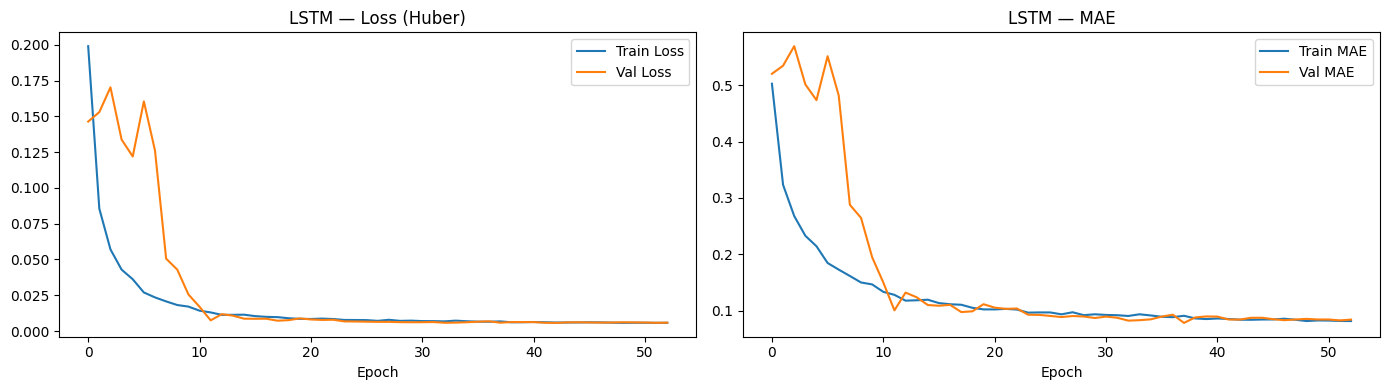

In [19]:
# ── 9.7  Training curves ──────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(history_lstm.history['loss'],     label='Train Loss')
axes[0].plot(history_lstm.history['val_loss'], label='Val Loss')
axes[0].set_title('LSTM — Loss (Huber)')
axes[0].set_xlabel('Epoch')
axes[0].legend()

axes[1].plot(history_lstm.history['mae'],     label='Train MAE')
axes[1].plot(history_lstm.history['val_mae'], label='Val MAE')
axes[1].set_title('LSTM — MAE')
axes[1].set_xlabel('Epoch')
axes[1].legend()

plt.tight_layout()
plt.show()


In [20]:
# ── 9.8  Validation predictions ───────────────────────────────────────────────
lstm_val_preds_scaled = lstm_model.predict(X_lstm_val).flatten()

# Inverse-scale back to original sales units
lstm_val_preds = scaler_lstm.inverse_transform(
    lstm_val_preds_scaled.reshape(-1, 1)
).flatten()

lstm_val_actuals = scaler_lstm.inverse_transform(
    y_lstm_val.reshape(-1, 1)
).flatten()

lstm_smape_score = smape_raw(lstm_val_preds, lstm_val_actuals)
lstm_mae_score   = mean_absolute_error(lstm_val_actuals, lstm_val_preds)
lstm_rmse_score  = np.sqrt(mean_squared_error(lstm_val_actuals, lstm_val_preds))

print(f"LSTM Validation SMAPE : {lstm_smape_score:.4f}")
print(f"LSTM Validation MAE   : {lstm_mae_score:.2f}")
print(f"LSTM Validation RMSE  : {lstm_rmse_score:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 568ms/step
LSTM Validation SMAPE : 10.4421
LSTM Validation MAE   : 2794.37
LSTM Validation RMSE  : 3542.12


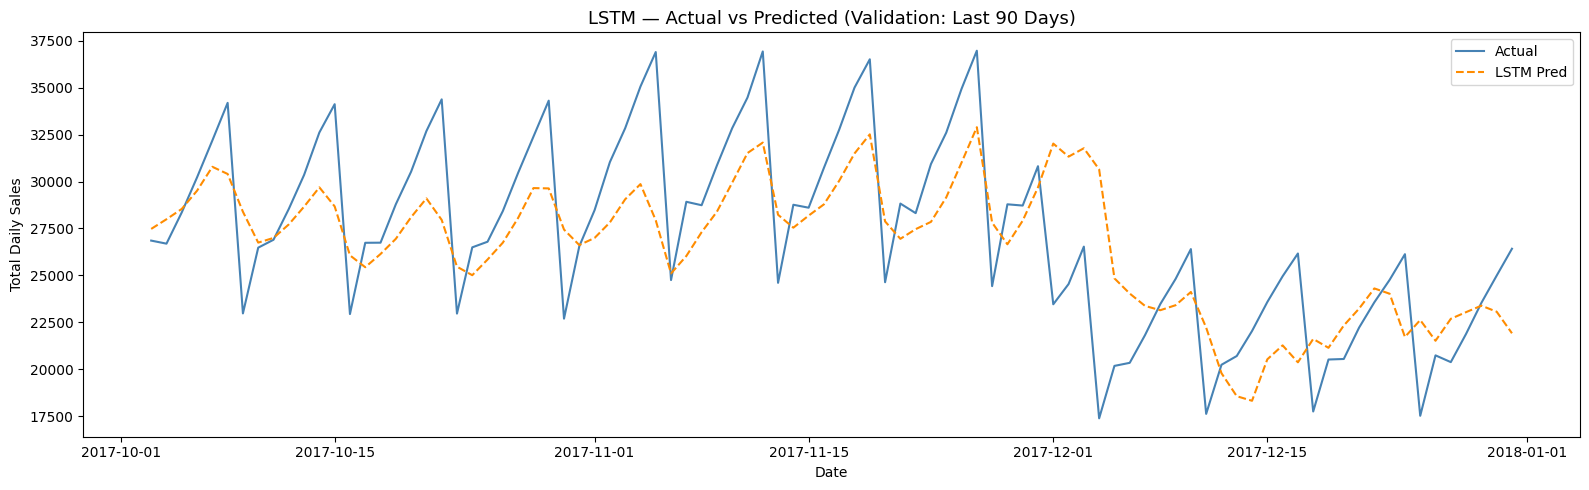

In [21]:
# ── 9.9  Actual vs Predicted plot ─────────────────────────────────────────────
val_dates = daily_sales['date'].values[-LSTM_HORIZON:]

plt.figure(figsize=(16, 5))
plt.plot(val_dates, lstm_val_actuals, label='Actual',    color='steelblue',  linewidth=1.5)
plt.plot(val_dates, lstm_val_preds,   label='LSTM Pred', color='darkorange', linewidth=1.5, linestyle='--')
plt.title('LSTM — Actual vs Predicted (Validation: Last 90 Days)', fontsize=13)
plt.xlabel('Date')
plt.ylabel('Total Daily Sales')
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
# ── 9.10  Rolling 90-day forecast (future) ────────────────────────────────────
def lstm_recursive_forecast(model, last_window_scaled, horizon, scaler):
    """
    Recursively forecast `horizon` steps ahead using the trained LSTM.
    Each predicted step is fed back as input for the next prediction.

    Parameters
    ----------
    model              : trained Keras LSTM model
    last_window_scaled : np.array of shape (window_size,) — last known values (scaled)
    horizon            : int — number of steps to forecast
    scaler             : fitted MinMaxScaler used on the training data

    Returns
    -------
    forecasts          : np.array of shape (horizon,) in original scale
    """
    current_window = last_window_scaled.copy().tolist()
    forecasts = []

    for _ in range(horizon):
        x_input = np.array(current_window[-LSTM_WINDOW:]).reshape(1, LSTM_WINDOW, 1)
        pred_scaled = model.predict(x_input, verbose=0)[0][0]
        forecasts.append(pred_scaled)
        current_window.append(pred_scaled)

    forecasts_original = scaler.inverse_transform(
        np.array(forecasts).reshape(-1, 1)
    ).flatten()

    return forecasts_original


# The last LSTM_WINDOW scaled values from the training data
last_known_scaled = sales_scaled[-LSTM_WINDOW:]

lstm_3month_forecast = lstm_recursive_forecast(
    lstm_model, last_known_scaled, LSTM_HORIZON, scaler_lstm
)

# Build forecast date range: the 90 days after 2017-12-31
forecast_dates_lstm = pd.date_range(
    start=daily_sales['date'].max() + pd.Timedelta(days=1),
    periods=LSTM_HORIZON,
    freq='D'
)

lstm_forecast_df = pd.DataFrame({
    'date':  forecast_dates_lstm,
    'sales': lstm_3month_forecast
})

print("LSTM 3-Month Forecast (first 10 rows):")
lstm_forecast_df.head(10)


LSTM 3-Month Forecast (first 10 rows):


,date,sales
0,2018-01-01,21859.958984
1,2018-01-02,21204.466797
2,2018-01-03,21798.054688
3,2018-01-04,22582.027344
4,2018-01-05,23178.923828
5,2018-01-06,23344.386719
6,2018-01-07,21932.175781
7,2018-01-08,21834.103516
8,2018-01-09,22032.980469
9,2018-01-10,22551.314453


## 10) DeepAR Model (New) — PyTorch
We implement a DeepAR‑style probabilistic forecaster: LSTM encoder → mean/scale (μ, σ) for a Gaussian likelihood; train with Gaussian NLL; at inference sample trajectories to get P10/P50/P90.

Input: (batch, seq_len, 1)
  → LSTM encoder (2 layers, hidden=128)
  → Linear → μ  (predicted mean)
  → Linear → log_σ (predicted log-std, softplus activation)
  → Gaussian NLL loss during training
  → At inference: sample from N(μ, σ²) for probabilistic forecasts


In [23]:
# ── 10.1  Build multi-series dataset (store × item level) ─────────────────────
train_raw_deepar = train

DEEPAR_CONTEXT  = 90    # encoder context length
DEEPAR_HORIZON  = 90    # decoder / forecast horizon
DEEPAR_EPOCHS   = 30
DEEPAR_BATCH    = 256
DEEPAR_HIDDEN   = 128
DEEPAR_LAYERS   = 2
DEEPAR_LR       = 1e-3

# Pivot to (date × series) matrix — shape: (n_days, 500)
sales_pivot = (
    train_raw_deepar
    .assign(series_id=lambda d: d['store'].astype(str) + '_' + d['item'].astype(str))
    .pivot(index='date', columns='series_id', values='sales')
    .sort_index()
)

print(f"Pivot shape: {sales_pivot.shape}  (days × series)")
sales_pivot.iloc[:3, :5]

Pivot shape: (1826, 500)  (days × series)


series_id,10_1,10_10,10_11,10_12,10_13
date,,,,,
2013-01-01,14,45,49,41,46
2013-01-02,14,50,47,36,57
2013-01-03,16,53,60,39,36


In [24]:
# ── 10.2  Scale each series independently with MinMaxScaler ───────────────────
scalers_deepar = {}
sales_scaled_pivot = sales_pivot.copy()

for col in sales_pivot.columns:
    sc = MinMaxScaler(feature_range=(0, 1))
    sales_scaled_pivot[col] = sc.fit_transform(
        sales_pivot[[col]]
    ).flatten()
    scalers_deepar[col] = sc

print("All series scaled. Sample:")
sales_scaled_pivot.iloc[:3, :5]

All series scaled. Sample:


series_id,10_1,10_10,10_11,10_12,10_13
date,,,,,
2013-01-01,0.20,0.104839,0.191667,0.123967,0.105960
2013-01-02,0.20,0.145161,0.175000,0.082645,0.178808
2013-01-03,0.24,0.169355,0.283333,0.107438,0.039735


In [25]:
# ── 10.3  Create sliding-window samples across ALL series ─────────────────────
def build_deepar_dataset(scaled_df, context_len, horizon):
    """
    For every series and every valid window position, produce
    a (context, target) pair.

    Returns
    -------
    contexts : np.array  (N, context_len, 1)
    targets  : np.array  (N, horizon)
    """
    arr = scaled_df.values                  # shape: (T, n_series)
    T, n_series = arr.shape
    step = context_len + horizon

    contexts, targets = [], []
    for s in range(n_series):
        series = arr[:, s]
        for start in range(0, T - step + 1, horizon):   # non-overlapping windows
            ctx = series[start : start + context_len]
            tgt = series[start + context_len : start + step]
            contexts.append(ctx)
            targets.append(tgt)

    contexts = np.array(contexts, dtype=np.float32).reshape(-1, context_len, 1)
    targets  = np.array(targets,  dtype=np.float32)
    return contexts, targets


# Use data up to 2016-12-31 for training, last window for validation
cutoff_idx   = (sales_scaled_pivot.index < '2017-01-01').sum()
train_pivot  = sales_scaled_pivot.iloc[:cutoff_idx]
val_pivot    = sales_scaled_pivot.iloc[cutoff_idx - DEEPAR_CONTEXT : cutoff_idx + DEEPAR_HORIZON]

X_ctx_train, y_tgt_train = build_deepar_dataset(train_pivot, DEEPAR_CONTEXT, DEEPAR_HORIZON)

print(f"DeepAR training samples  : {X_ctx_train.shape}")
print(f"DeepAR target shape      : {y_tgt_train.shape}")

DeepAR training samples  : (7500, 90, 1)
DeepAR target shape      : (7500, 90)


In [26]:
# ── 10.4  PyTorch Dataset and DataLoader ──────────────────────────────────────
X_ctx_t = torch.tensor(X_ctx_train, dtype=torch.float32)
y_tgt_t = torch.tensor(y_tgt_train, dtype=torch.float32)

deepar_dataset = TensorDataset(X_ctx_t, y_tgt_t)
deepar_loader  = DataLoader(
    deepar_dataset, batch_size=DEEPAR_BATCH, shuffle=True
)

print(f"Number of batches per epoch: {len(deepar_loader)}")


Number of batches per epoch: 30


In [27]:
# ── 10.5  DeepAR Model Definition ────────────────────────────────────────────
class DeepARModel(nn.Module):
    """
    DeepAR-style probabilistic forecaster.

    Encodes the context sequence with a multi-layer LSTM, then produces
    per-step Gaussian parameters (mu, sigma) for each step in the
    forecast horizon via teacher-forced decoding during training.
    """

    def __init__(self, input_size=1, hidden_size=128, num_layers=2,
                 horizon=90, dropout=0.1):
        super(DeepARModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers  = num_layers
        self.horizon     = horizon

        # Encoder LSTM
        self.encoder = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

        # Decoder LSTM (same size — shares the hidden state from encoder)
        self.decoder = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

        # Output heads — produce (mu, log_sigma) for the Gaussian distribution
        self.fc_mu    = nn.Linear(hidden_size, 1)
        self.fc_sigma = nn.Linear(hidden_size, 1)

    def forward(self, context, target=None):
        """
        Parameters
        ----------
        context : Tensor (batch, context_len, 1)
        target  : Tensor (batch, horizon) — only used during training
                  for teacher forcing; pass None at inference.

        Returns
        -------
        mu    : Tensor (batch, horizon)
        sigma : Tensor (batch, horizon)  — always positive
        """
        # ── Encode the context ────────────────────────────────────────────────
        _, (h, c) = self.encoder(context)

        # ── Decode step by step ───────────────────────────────────────────────
        mus, sigmas = [], []

        # Seed the decoder with the last observed value of the context
        dec_input = context[:, -1:, :]   # shape: (batch, 1, 1)

        for t in range(self.horizon):
            dec_out, (h, c) = self.decoder(dec_input, (h, c))

            mu_t    = self.fc_mu(dec_out.squeeze(1))               # (batch, 1)
            sigma_t = torch.nn.functional.softplus(               # ensure σ > 0
                self.fc_sigma(dec_out.squeeze(1))
            ) + 1e-6

            mus.append(mu_t)
            sigmas.append(sigma_t)

            # Teacher forcing: feed the actual next value during training
            if target is not None:
                dec_input = target[:, t].unsqueeze(1).unsqueeze(2)
            else:
                dec_input = mu_t.unsqueeze(1)     # autoregressive at inference

        mu    = torch.cat(mus,    dim=1)   # (batch, horizon)
        sigma = torch.cat(sigmas, dim=1)   # (batch, horizon)
        return mu, sigma


deepar_model = DeepARModel(
    input_size=1,
    hidden_size=DEEPAR_HIDDEN,
    num_layers=DEEPAR_LAYERS,
    horizon=DEEPAR_HORIZON,
    dropout=0.1
)

total_params = sum(p.numel() for p in deepar_model.parameters() if p.requires_grad)
print(deepar_model)
print(f"\nTotal trainable parameters: {total_params:,}")

DeepARModel(
  (encoder): LSTM(1, 128, num_layers=2, batch_first=True, dropout=0.1)
  (decoder): LSTM(1, 128, num_layers=2, batch_first=True, dropout=0.1)
  (fc_mu): Linear(in_features=128, out_features=1, bias=True)
  (fc_sigma): Linear(in_features=128, out_features=1, bias=True)
)

Total trainable parameters: 398,594


In [28]:
# ── 10.6  Gaussian Negative Log-Likelihood Loss ───────────────────────────────
def gaussian_nll_loss(mu, sigma, target):
    """
    Mean Gaussian NLL:
        L = 0.5 * log(2π σ²) + (y - μ)² / (2σ²)
    Using PyTorch's built-in GaussianNLLLoss for numerical stability.
    """
    loss_fn = nn.GaussianNLLLoss(full=False, reduction='mean')
    return loss_fn(mu, target, sigma ** 2)


In [29]:
# ── 10.7  Training loop ───────────────────────────────────────────────────────
optimizer_deepar = torch.optim.Adam(deepar_model.parameters(), lr=DEEPAR_LR)
scheduler_deepar = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_deepar, mode='min', factor=0.5, patience=3
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on: {device}")
deepar_model.to(device)

epoch_losses = []

for epoch in range(DEEPAR_EPOCHS):
    deepar_model.train()
    batch_losses = []

    for batch_ctx, batch_tgt in deepar_loader:
        batch_ctx = batch_ctx.to(device)
        batch_tgt = batch_tgt.to(device)

        optimizer_deepar.zero_grad()

        # Forward pass with teacher forcing
        mu, sigma = deepar_model(batch_ctx, batch_tgt)

        loss = gaussian_nll_loss(mu, sigma, batch_tgt)
        loss.backward()

        # Gradient clipping for training stability
        torch.nn.utils.clip_grad_norm_(deepar_model.parameters(), max_norm=1.0)
        optimizer_deepar.step()
        batch_losses.append(loss.item())

    epoch_loss = np.mean(batch_losses)
    epoch_losses.append(epoch_loss)
    scheduler_deepar.step(epoch_loss)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1:02d}/{DEEPAR_EPOCHS}]  NLL Loss: {epoch_loss:.5f}")


Training on: cpu
Epoch [05/30]  NLL Loss: -1.53947
Epoch [10/30]  NLL Loss: -1.62484
Epoch [15/30]  NLL Loss: -1.63346
Epoch [20/30]  NLL Loss: -1.64128
Epoch [25/30]  NLL Loss: -1.72015
Epoch [30/30]  NLL Loss: -1.82418


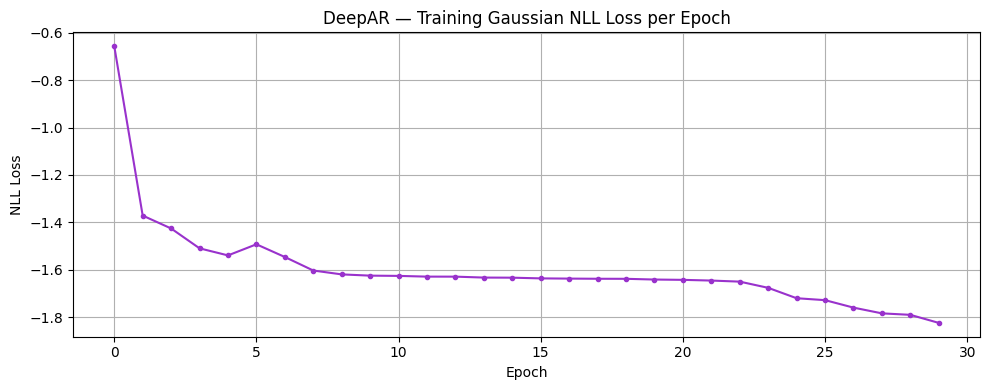

In [30]:
# ── 10.8  Plot training loss ──────────────────────────────────────────────────
plt.figure(figsize=(10, 4))
plt.plot(epoch_losses, marker='o', markersize=3, color='darkorchid')
plt.title('DeepAR — Training Gaussian NLL Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('NLL Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
# ── 10.9  Probabilistic inference: generate P10 / P50 (median) / P90 ─────────
N_SAMPLES = 200    # Monte Carlo samples drawn from the predicted Gaussian

def deepar_predict_series(model, context_array, scaler, n_samples=200):
    """
    Run DeepAR inference on a single series.

    Parameters
    ----------
    model         : trained DeepARModel
    context_array : np.array (context_len,) in SCALED space
    scaler        : fitted MinMaxScaler for this series
    n_samples     : number of Monte Carlo samples for prediction intervals

    Returns
    -------
    dict with keys: 'p10', 'p50', 'p90'  — each shape (horizon,)
    """
    model.eval()
    ctx_t = torch.tensor(
        context_array.reshape(1, -1, 1), dtype=torch.float32
    ).to(device)

    sampled_paths = []

    with torch.no_grad():
        for _ in range(n_samples):
            mu, sigma = model(ctx_t, target=None)   # autoregressive
            # Sample from the predicted Gaussian distribution
            sample = torch.normal(mu, sigma).cpu().numpy().flatten()
            sampled_paths.append(sample)

    sampled_paths = np.array(sampled_paths)   # (n_samples, horizon)

    # Inverse-scale each sample
    p10 = scaler.inverse_transform(
        np.percentile(sampled_paths, 10, axis=0).reshape(-1, 1)
    ).flatten()
    p50 = scaler.inverse_transform(
        np.percentile(sampled_paths, 50, axis=0).reshape(-1, 1)
    ).flatten()
    p90 = scaler.inverse_transform(
        np.percentile(sampled_paths, 90, axis=0).reshape(-1, 1)
    ).flatten()

    return {'p10': p10, 'p50': p50, 'p90': p90}

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Correctly initialize device as a torch.device object
# Removed: deice = 'CPU' (this was a typo and not needed)
# ── 10.10  Run inference on a representative series: Store 1, Item 1 ──────────
DEMO_SERIES = '1_1'

# Scaled context window: last DEEPAR_CONTEXT days before 2017-01-01
context_series = sales_scaled_pivot[DEMO_SERIES].values[
    cutoff_idx - DEEPAR_CONTEXT : cutoff_idx
]

# Actual validation values (unscaled)
actual_val_series = sales_pivot[DEMO_SERIES].values[
    cutoff_idx : cutoff_idx + DEEPAR_HORIZON
]

deepar_preds = deepar_predict_series(
    deepar_model, context_series,
    scalers_deepar[DEMO_SERIES], N_SAMPLES
)

deepar_smape_score = smape_raw(deepar_preds['p50'], actual_val_series)
deepar_mae_score   = mean_absolute_error(actual_val_series, deepar_preds['p50'])
deepar_rmse_score  = np.sqrt(mean_squared_error(actual_val_series, deepar_preds['p50']))

print(f"DeepAR (Store 1, Item 1) Validation SMAPE : {deepar_smape_score:.4f}")
print(f"DeepAR (Store 1, Item 1) Validation MAE   : {deepar_mae_score:.2f}")
print(f"DeepAR (Store 1, Item 1) Validation RMSE  : {deepar_rmse_score:.2f}")

DeepAR (Store 1, Item 1) Validation SMAPE : 32.8416
DeepAR (Store 1, Item 1) Validation MAE   : 5.18
DeepAR (Store 1, Item 1) Validation RMSE  : 6.77


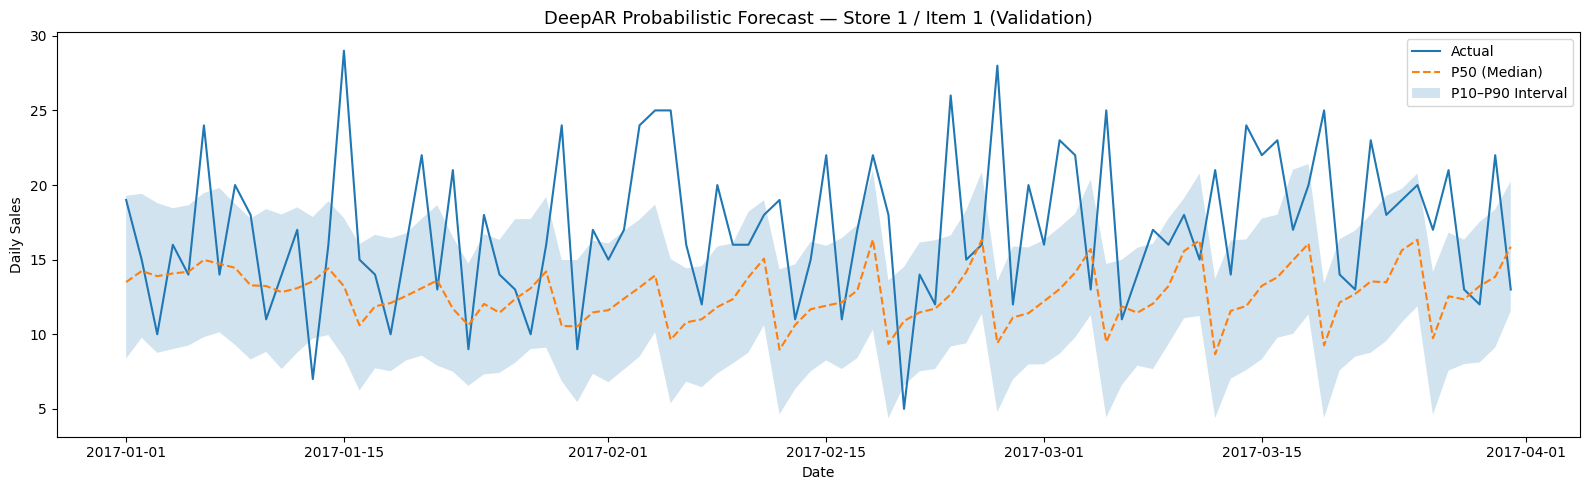

In [33]:
# ── 10.11  Plot DeepAR probabilistic forecast ─────────────────────────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Choose the series you want to plot ---
STORE_ID = 1
ITEM_ID  = 1

# sales_pivot: index=date, columns=series like "1_1" or similar
# If your column naming is different, adjust series_key accordingly.
series_key = f"{STORE_ID}_{ITEM_ID}"

# Define val_dates_deepar based on the sales_pivot and cutoff_idx
# The validation period starts at cutoff_idx and lasts for DEEPAR_HORIZON days.
val_dates_deepar = sales_pivot.index[cutoff_idx : cutoff_idx + DEEPAR_HORIZON]

# 1) Actual validation series (raw)
actual_val_series = sales_pivot.loc[val_dates_deepar, series_key].values

# 2) Ensure DeepAR quantiles are numpy arrays aligned to horizon
p10 = np.asarray(deepar_preds["p10"])[:DEEPAR_HORIZON]
p50 = np.asarray(deepar_preds["p50"])[:DEEPAR_HORIZON]
p90 = np.asarray(deepar_preds["p90"])[:DEEPAR_HORIZON]

# 3) Plot
plt.figure(figsize=(16, 5))
plt.plot(val_dates_deepar, actual_val_series, label="Actual", linewidth=1.5)
plt.plot(val_dates_deepar, p50, label="P50 (Median)", linewidth=1.5, linestyle="--")
plt.fill_between(val_dates_deepar, p10, p90, alpha=0.2, label="P10–P90 Interval")
plt.title(f"DeepAR Probabilistic Forecast — Store {STORE_ID} / Item {ITEM_ID} (Validation)", fontsize=13)
plt.xlabel("Date")
plt.ylabel("Daily Sales")
plt.legend()
plt.tight_layout()
plt.show()


In [34]:
# ── 10.12  Aggregate DeepAR: compute median SMAPE across all 500 series ───────
# NOTE: This cell can take a few minutes as it runs inference on all 500 series.
all_smapes = []

for series_id in sales_pivot.columns:
    try:
        ctx = sales_scaled_pivot[series_id].values[
            cutoff_idx - DEEPAR_CONTEXT : cutoff_idx
        ]
        actuals = sales_pivot[series_id].values[
            cutoff_idx : cutoff_idx + DEEPAR_HORIZON
        ]

        if len(ctx) < DEEPAR_CONTEXT or len(actuals) < DEEPAR_HORIZON:
            continue

        preds = deepar_predict_series(
            deepar_model, ctx, scalers_deepar[series_id], n_samples=50
        )
        all_smapes.append(smape_raw(preds['p50'], actuals))
    except Exception:
        continue

deepar_agg_smape = np.median(all_smapes)
print(f"DeepAR Aggregate Median SMAPE (all 500 series): {deepar_agg_smape:.4f}")

DeepAR Aggregate Median SMAPE (all 500 series): 32.1492


In [35]:
# ── 11.1  Collect all model metrics ───────────────────────────────────────────
# LightGBM MAE / RMSE (on log-scale predictions, inverted)
lgbm_preds_orig   = np.expm1(pred_val)
lgbm_actuals_orig = np.expm1(y_val)

lgbm_mae_score  = mean_absolute_error(lgbm_actuals_orig, lgbm_preds_orig)
lgbm_rmse_score = np.sqrt(mean_squared_error(lgbm_actuals_orig, lgbm_preds_orig))

results = pd.DataFrame([
    {
        'Model'  : 'LightGBM',
        'SMAPE'  : round(smape_score,      4),
        'MAE'    : round(lgbm_mae_score,         2),
        'RMSE'   : round(lgbm_rmse_score,        2),
        'Type'   : 'Gradient Boosting',
        'Notes'  : 'Lag + EWM + rolling features; per-row prediction'
    },
    {
        'Model'  : 'Bidirectional LSTM',
        'SMAPE'  : round(lstm_smape_score,       4),
        'MAE'    : round(lstm_mae_score,          2),
        'RMSE'   : round(lstm_rmse_score,         2),
        'Type'   : 'Deep Learning (RNN)',
        'Notes'  : 'Aggregated series; recursive 90-day forecast'
    },
    {
        'Model'  : 'DeepAR (P50)',
        'SMAPE'  : round(deepar_agg_smape,       4),
        'MAE'    : round(deepar_mae_score,        2),
        'RMSE'   : round(deepar_rmse_score,       2),
        'Type'   : 'Probabilistic Deep Learning',
        'Notes'  : 'Trains jointly on 500 series; gives prediction intervals'
    }
])

results = results.sort_values('SMAPE').reset_index(drop=True)
print("\n📊 Model Comparison Table (sorted by SMAPE ↑ = better)")
results


📊 Model Comparison Table (sorted by SMAPE ↑ = better)


,Model,SMAPE,MAE,RMSE,Type,Notes
0,Bidirectional LSTM,10.4421,2794.37,3542.12,Deep Learning (RNN),Aggregated series; recursive 90-day forecast
1,LightGBM,13.5708,5.40,7.00,Gradient Boosting,Lag + EWM + rolling features; per-row prediction
2,DeepAR (P50),32.1492,5.18,6.77,Probabilistic Deep Learning,Trains jointly on 500 series; gives prediction...


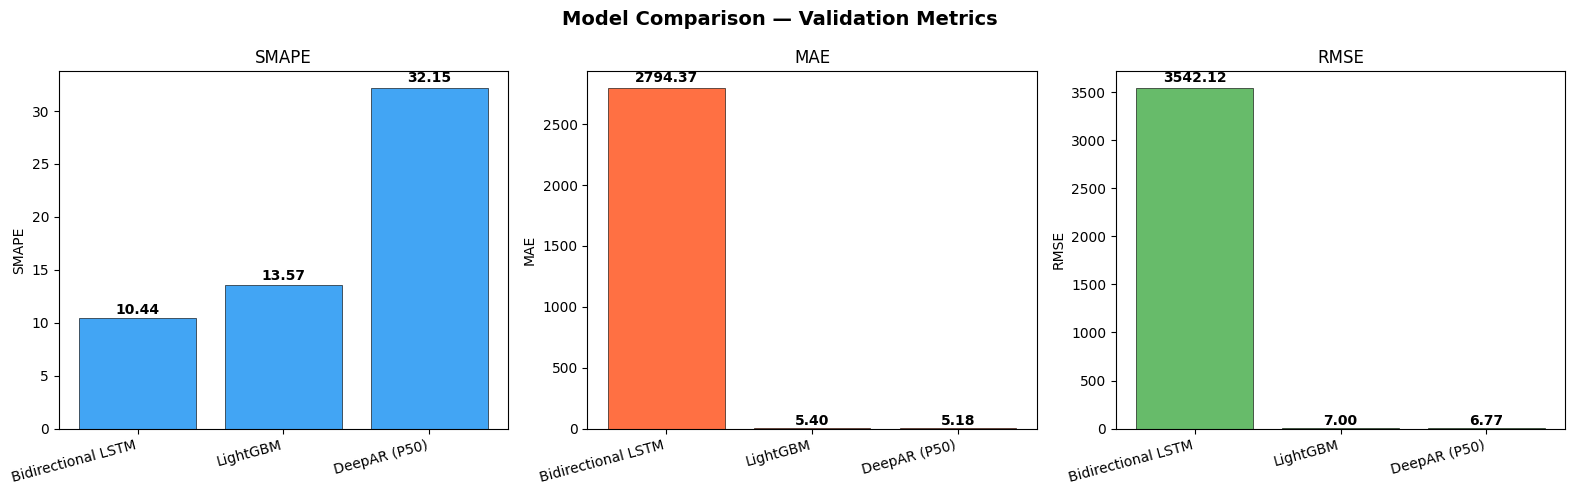

In [36]:
# ── 11.2  Comparison bar charts ───────────────────────────────────────────────
metrics    = ['SMAPE', 'MAE', 'RMSE']
colors     = ['#2196F3', '#FF5722', '#4CAF50']
model_names = results['Model'].tolist()

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Model Comparison — Validation Metrics', fontsize=14, fontweight='bold')

for ax, metric, color in zip(axes, metrics, colors):
    bars = ax.bar(model_names, results[metric], color=color, alpha=0.85, edgecolor='black', linewidth=0.5)
    ax.set_title(metric, fontsize=12)
    ax.set_ylabel(metric)
    ax.set_xticklabels(model_names, rotation=15, ha='right')
    for bar, val_ in zip(bars, results[metric]):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.01 * bar.get_height(),
            f'{val_:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold'
        )

plt.tight_layout()
plt.show()


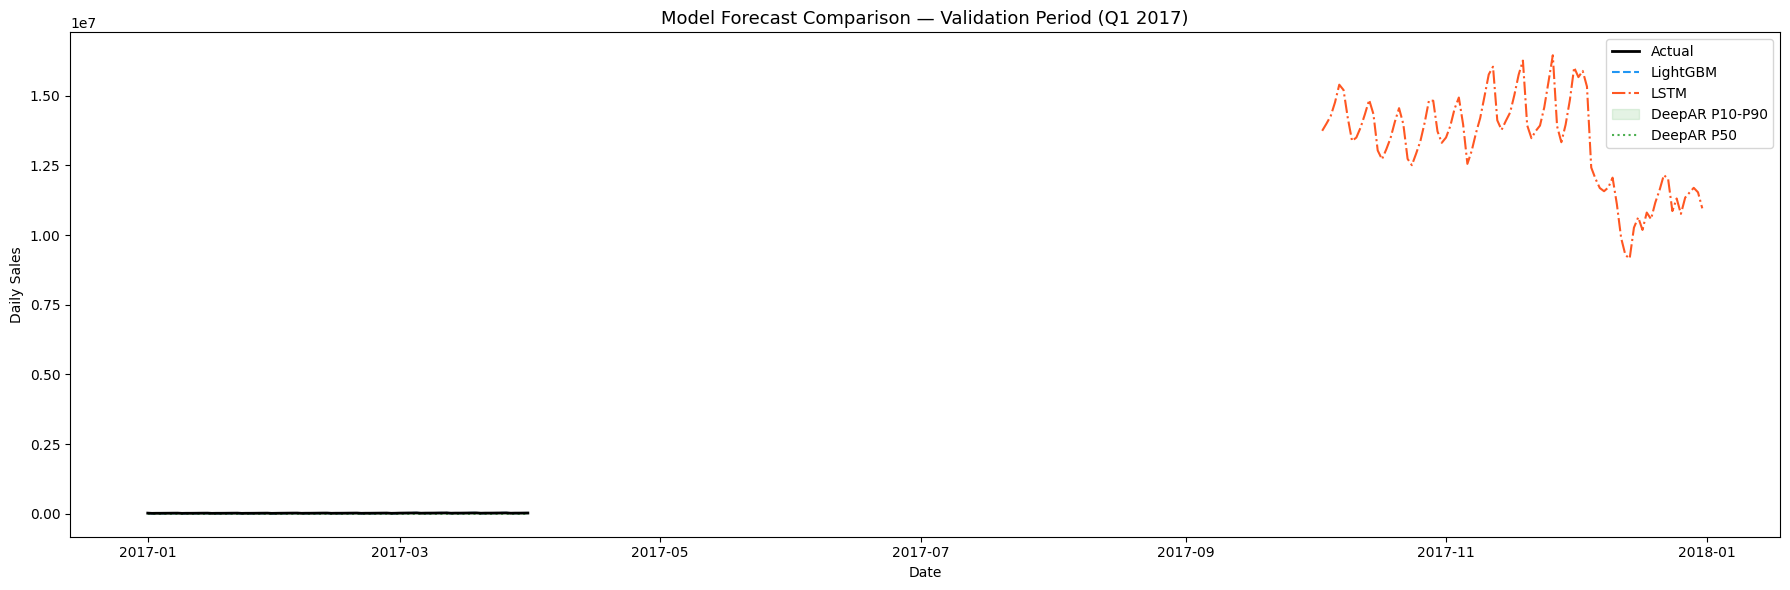

In [37]:
# ── 11.3  Overlay forecast comparison on the same axis ────────────────────────
# Convert LGBM val predictions to daily total scale for a fair visual comparison
val_dates_compare = val_lgb['date'].unique()[:LSTM_HORIZON]

# LightGBM: aggregate store-item predictions to total daily sales
lgbm_daily = (
    pd.DataFrame({'date': val_lgb['date'], 'pred': lgbm_preds_orig})
    .groupby('date')['pred'].sum()
    .reset_index()
    .sort_values('date')
)

lgbm_daily_actuals = (
    pd.DataFrame({'date': val_lgb['date'], 'actual': lgbm_actuals_orig})
    .groupby('date')['actual'].sum()
    .reset_index()
    .sort_values('date')
)

n_common = min(len(lgbm_daily), len(lstm_val_preds), len(deepar_preds['p50']))

plt.figure(figsize=(18, 6))
plt.plot(
    lgbm_daily_actuals['date'].values[:n_common],
    lgbm_daily_actuals['actual'].values[:n_common],
    label='Actual', color='black', linewidth=2, zorder=5
)
plt.plot(
    lgbm_daily['date'].values[:n_common],
    lgbm_daily['pred'].values[:n_common],
    label='LightGBM', color='#2196F3', linewidth=1.5, linestyle='--'
)
plt.plot(
    val_dates[:n_common],
    lstm_val_preds[:n_common] * 500,   # scale to approximate total across 500 series
    label='LSTM', color='#FF5722', linewidth=1.5, linestyle='-.'
)
plt.fill_between(
    val_dates_deepar[:n_common],
    deepar_preds['p10'][:n_common],
    deepar_preds['p90'][:n_common],
    alpha=0.15, color='#4CAF50', label='DeepAR P10-P90'
)
plt.plot(
    val_dates_deepar[:n_common],
    deepar_preds['p50'][:n_common],
    label='DeepAR P50', color='#4CAF50', linewidth=1.5, linestyle=':'
)
plt.title('Model Forecast Comparison — Validation Period (Q1 2017)', fontsize=13)
plt.xlabel('Date')
plt.ylabel('Daily Sales')
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
# ── 11.4  Select best model based on SMAPE ────────────────────────────────────
best_model_name = results.iloc[0]['Model']
best_smape      = results.iloc[0]['SMAPE']

print(f"\n🏆 Best Model  : {best_model_name}")
print(f"   SMAPE Score : {best_smape:.4f}")
print(f"\nFull leaderboard:")
print(results[['Model', 'SMAPE', 'MAE', 'RMSE', 'Type']].to_string(index=False))


🏆 Best Model  : Bidirectional LSTM
   SMAPE Score : 10.4421

Full leaderboard:
             Model   SMAPE     MAE    RMSE                        Type
Bidirectional LSTM 10.4421 2794.37 3542.12         Deep Learning (RNN)
          LightGBM 13.5708    5.40    7.00           Gradient Boosting
      DeepAR (P50) 32.1492    5.18    6.77 Probabilistic Deep Learning


In [39]:
# ── 12.1  LightGBM 3-month forecast (already computed above as lgbm_test_preds)
lgbm_3month_df = pd.DataFrame({
    'date'  : test_df['date'].values,
    'store' : test_df['store'].values,
    'item'  : test_df['item'].values,
    'sales' : np.expm1(lgbm_test_preds)
})

lgbm_daily_forecast = (
    lgbm_3month_df
    .groupby('date')['sales'].sum()
    .reset_index()
    .rename(columns={'sales': 'total_sales'})
)

print(f"LightGBM forecast: {lgbm_3month_df.shape[0]} store-item-day rows")
print(f"Date range        : {lgbm_3month_df.date.min().date()} → {lgbm_3month_df.date.max().date()}")
lgbm_3month_df.head()


LightGBM forecast: 45000 store-item-day rows
Date range        : 2018-01-01 → 2018-03-31


,date,store,item,sales
0,2018-01-01,1,1,11.832029
1,2018-01-02,1,1,13.332679
2,2018-01-03,1,1,13.837442
3,2018-01-04,1,1,14.787533
4,2018-01-05,1,1,16.200401


In [40]:
# ── 12.2  LSTM 3-month forecast (already computed above as lstm_forecast_df) ──
print("LSTM 3-Month Forecast (total daily sales):")
lstm_forecast_df.head(10)

LSTM 3-Month Forecast (total daily sales):


,date,sales
0,2018-01-01,21859.958984
1,2018-01-02,21204.466797
2,2018-01-03,21798.054688
3,2018-01-04,22582.027344
4,2018-01-05,23178.923828
5,2018-01-06,23344.386719
6,2018-01-07,21932.175781
7,2018-01-08,21834.103516
8,2018-01-09,22032.980469
9,2018-01-10,22551.314453


In [41]:
# ── 12.3  DeepAR 3-month forecast: median prediction per series ───────────────
# Context: the last DEEPAR_CONTEXT days of the known training data
deepar_all_forecasts = {}

for series_id in sales_pivot.columns:
    ctx = sales_scaled_pivot[series_id].values[-DEEPAR_CONTEXT:]
    if len(ctx) < DEEPAR_CONTEXT:
        continue
    preds = deepar_predict_series(
        deepar_model, ctx, scalers_deepar[series_id], n_samples=100
    )
    deepar_all_forecasts[series_id] = preds

# Aggregate: total daily sales = sum over all 500 series
deepar_total_daily = np.zeros(DEEPAR_HORIZON)
for series_id, preds in deepar_all_forecasts.items():
    deepar_total_daily += preds['p50']

deepar_p10_total = np.zeros(DEEPAR_HORIZON)
deepar_p90_total = np.zeros(DEEPAR_HORIZON)
for series_id, preds in deepar_all_forecasts.items():
    deepar_p10_total += preds['p10']
    deepar_p90_total += preds['p90']

forecast_dates_deepar = pd.date_range(
    start=sales_pivot.index[-1] + pd.Timedelta(days=1),
    periods=DEEPAR_HORIZON, freq='D'
)

deepar_forecast_df = pd.DataFrame({
    'date'       : forecast_dates_deepar,
    'sales_p10'  : deepar_p10_total,
    'sales_p50'  : deepar_total_daily,
    'sales_p90'  : deepar_p90_total
})

print("DeepAR 3-Month Aggregate Forecast (first 10 rows):")
deepar_forecast_df.head(10)


DeepAR 3-Month Aggregate Forecast (first 10 rows):


,date,sales_p10,sales_p50,sales_p90
0,2018-01-01,14402.612498,19513.016402,24575.511017
1,2018-01-02,15316.451833,20209.268301,25122.263371
2,2018-01-03,16012.810769,20885.197600,25737.901709
3,2018-01-04,16438.531189,21337.577308,26207.446159
4,2018-01-05,17049.524423,22014.272608,27074.043001
5,2018-01-06,18049.102872,23248.502951,28457.044317
6,2018-01-07,15758.338374,21045.981040,26303.033916
7,2018-01-08,13020.520480,18064.834172,23060.720670
8,2018-01-09,14312.382639,19116.284303,23883.558724
9,2018-01-10,14830.625017,19553.583183,24294.868415


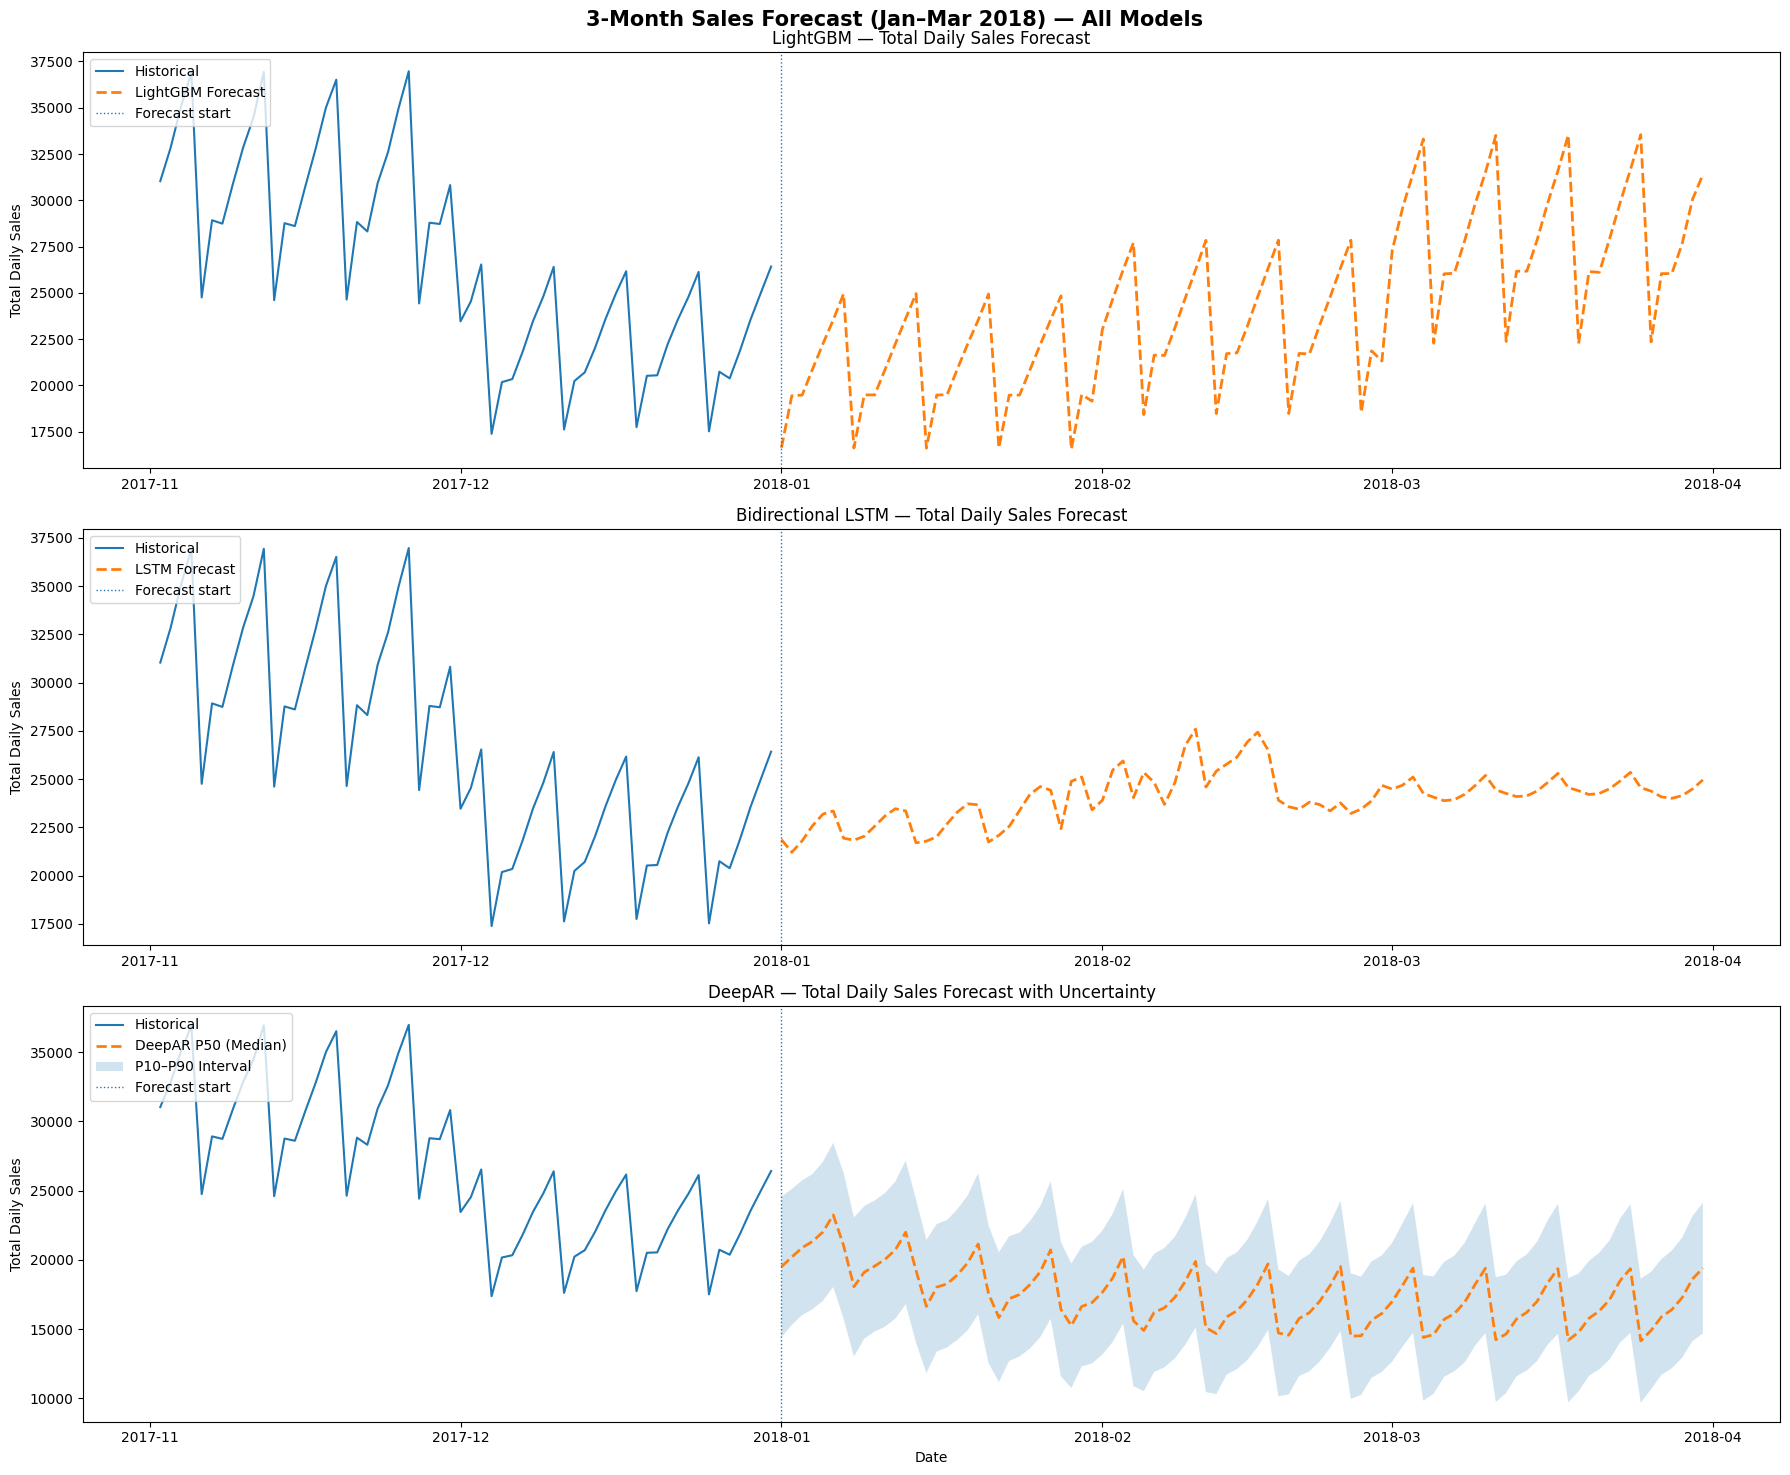

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

def _ensure_datetime(df, col="date"):
    if df is not None and col in df.columns:
        df[col] = pd.to_datetime(df[col])
    return df

# --- checks ---
required = {
    "daily_sales": ("date", "sales"),
    "lgbm_daily_forecast": ("date", "total_sales"),
    "lstm_forecast_df": ("date", "sales"),
    "deepar_forecast_df": ("date", "sales_p10", "sales_p50", "sales_p90"),
}

for name, cols in required.items():
    if name not in globals():
        print(f"Missing: {name} (run that model section first)")
    else:
        df_ = globals()[name]
        missing_cols = [c for c in cols if c not in df_.columns]
        if missing_cols:
            print(f"{name} is missing columns: {missing_cols}. Available: {list(df_.columns)}")

# --- make sure dates are datetime ---
daily_sales = _ensure_datetime(daily_sales, "date")
history_tail = daily_sales.tail(60)

if "lgbm_daily_forecast" in globals():
    lgbm_daily_forecast = _ensure_datetime(lgbm_daily_forecast, "date")
if "lstm_forecast_df" in globals():
    lstm_forecast_df = _ensure_datetime(lstm_forecast_df, "date")
if "deepar_forecast_df" in globals():
    deepar_forecast_df = _ensure_datetime(deepar_forecast_df, "date")

# --- plot ---
fig, axes = plt.subplots(3, 1, figsize=(18, 15))
fig.suptitle("3-Month Sales Forecast (Jan–Mar 2018) — All Models", fontsize=15, fontweight="bold")

# LightGBM
axes[0].plot(history_tail["date"], history_tail["sales"], label="Historical", linewidth=1.5)
if "lgbm_daily_forecast" in globals() and {"date","total_sales"}.issubset(lgbm_daily_forecast.columns):
    axes[0].plot(lgbm_daily_forecast["date"], lgbm_daily_forecast["total_sales"], label="LightGBM Forecast", linewidth=2, linestyle="--")
    axes[0].axvline(x=lgbm_daily_forecast["date"].min(), linestyle=":", linewidth=1, label="Forecast start")
axes[0].set_title("LightGBM — Total Daily Sales Forecast", fontsize=12)
axes[0].set_ylabel("Total Daily Sales")
axes[0].legend(loc="upper left")

# LSTM
axes[1].plot(history_tail["date"], history_tail["sales"], label="Historical", linewidth=1.5)
if "lstm_forecast_df" in globals() and {"date","sales"}.issubset(lstm_forecast_df.columns):
    axes[1].plot(lstm_forecast_df["date"], lstm_forecast_df["sales"], label="LSTM Forecast", linewidth=2, linestyle="--")
    axes[1].axvline(x=lstm_forecast_df["date"].min(), linestyle=":", linewidth=1, label="Forecast start")
axes[1].set_title("Bidirectional LSTM — Total Daily Sales Forecast", fontsize=12)
axes[1].set_ylabel("Total Daily Sales")
axes[1].legend(loc="upper left")

# DeepAR
axes[2].plot(history_tail["date"], history_tail["sales"], label="Historical", linewidth=1.5)
if "deepar_forecast_df" in globals() and {"date","sales_p10","sales_p50","sales_p90"}.issubset(deepar_forecast_df.columns):
    axes[2].plot(deepar_forecast_df["date"], deepar_forecast_df["sales_p50"], label="DeepAR P50 (Median)", linewidth=2, linestyle="--")
    axes[2].fill_between(deepar_forecast_df["date"], deepar_forecast_df["sales_p10"], deepar_forecast_df["sales_p90"], alpha=0.2, label="P10–P90 Interval")
    axes[2].axvline(x=deepar_forecast_df["date"].min(), linestyle=":", linewidth=1, label="Forecast start")
axes[2].set_title("DeepAR — Total Daily Sales Forecast with Uncertainty", fontsize=12)
axes[2].set_ylabel("Total Daily Sales")
axes[2].set_xlabel("Date")
axes[2].legend(loc="upper left")

plt.tight_layout()
plt.show()

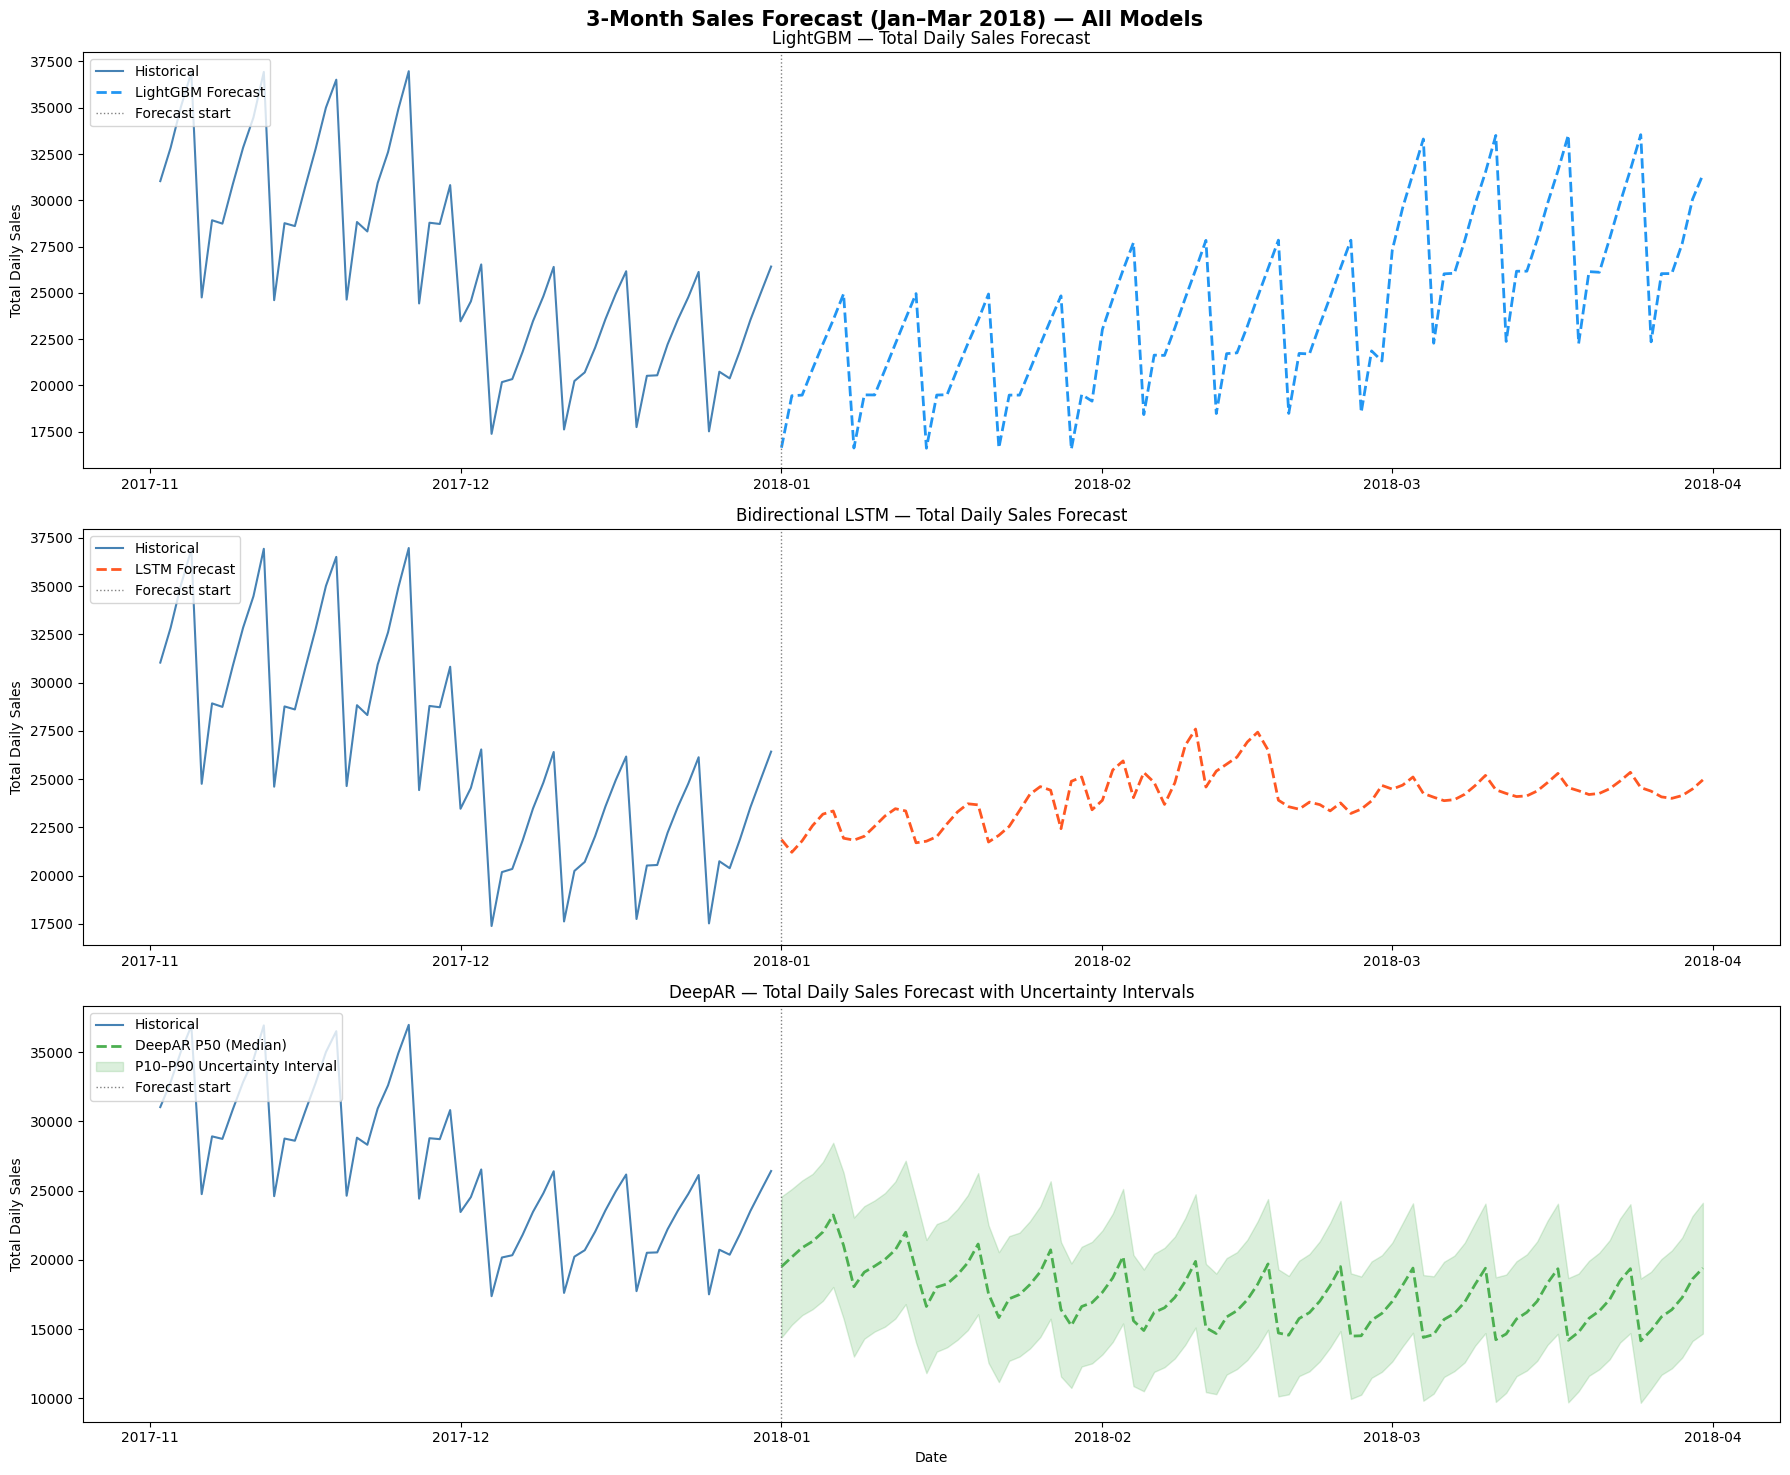

In [43]:
# ── 12.4  Side-by-side 3-month forecast plot ──────────────────────────────────
# Append the last 60 days of actuals for visual context
history_tail = daily_sales.tail(60)

fig, axes = plt.subplots(3, 1, figsize=(18, 15), sharex=False)
fig.suptitle('3-Month Sales Forecast (Jan–Mar 2018) — All Models', fontsize=15, fontweight='bold')

# ── LightGBM ──────────────────────────────────────────────────────────────────
axes[0].plot(history_tail['date'],    history_tail['sales'],
             label='Historical', color='steelblue', linewidth=1.5)
axes[0].plot(lgbm_daily_forecast['date'], lgbm_daily_forecast['total_sales'],
             label='LightGBM Forecast', color='#2196F3',
             linewidth=2, linestyle='--')
axes[0].axvline(x=lgbm_daily_forecast['date'].min(), color='grey',
                linestyle=':', linewidth=1, label='Forecast start')
axes[0].set_title('LightGBM — Total Daily Sales Forecast', fontsize=12)
axes[0].set_ylabel('Total Daily Sales')
axes[0].legend(loc='upper left')

# ── LSTM ──────────────────────────────────────────────────────────────────────
axes[1].plot(history_tail['date'], history_tail['sales'],
             label='Historical', color='steelblue', linewidth=1.5)
axes[1].plot(lstm_forecast_df['date'], lstm_forecast_df['sales'],
             label='LSTM Forecast', color='#FF5722',
             linewidth=2, linestyle='--')
axes[1].axvline(x=lstm_forecast_df['date'].min(), color='grey',
                linestyle=':', linewidth=1, label='Forecast start')
axes[1].set_title('Bidirectional LSTM — Total Daily Sales Forecast', fontsize=12)
axes[1].set_ylabel('Total Daily Sales')
axes[1].legend(loc='upper left')

# ── DeepAR ────────────────────────────────────────────────────────────────────
axes[2].plot(history_tail['date'], history_tail['sales'],
             label='Historical', color='steelblue', linewidth=1.5)
axes[2].plot(deepar_forecast_df['date'], deepar_forecast_df['sales_p50'],
             label='DeepAR P50 (Median)', color='#4CAF50',
             linewidth=2, linestyle='--')
axes[2].fill_between(
    deepar_forecast_df['date'],
    deepar_forecast_df['sales_p10'],
    deepar_forecast_df['sales_p90'],
    alpha=0.2, color='#4CAF50', label='P10–P90 Uncertainty Interval'
)
axes[2].axvline(x=deepar_forecast_df['date'].min(), color='grey',
                linestyle=':', linewidth=1, label='Forecast start')
axes[2].set_title('DeepAR — Total Daily Sales Forecast with Uncertainty Intervals', fontsize=12)
axes[2].set_ylabel('Total Daily Sales')
axes[2].set_xlabel('Date')
axes[2].legend(loc='upper left')

plt.tight_layout()
plt.show()


In [44]:
# ── 12.5  Monthly aggregation of the 3-month forecast ────────────────────────
def summarise_monthly(forecast_df, date_col, sales_col, label):
    return (
        forecast_df
        .assign(month=lambda d: d[date_col].dt.to_period('M'))
        .groupby('month')[sales_col].sum()
        .reset_index()
        .rename(columns={sales_col: label})
    )

lgbm_monthly  = summarise_monthly(lgbm_daily_forecast,   'date', 'total_sales', 'LightGBM')
lstm_monthly  = summarise_monthly(lstm_forecast_df,       'date', 'sales',       'LSTM')
deepar_monthly = summarise_monthly(deepar_forecast_df,    'date', 'sales_p50',   'DeepAR_P50')

monthly_summary = lgbm_monthly.merge(lstm_monthly,   on='month', how='outer') \
                               .merge(deepar_monthly, on='month', how='outer')

print("Monthly Forecast Summary — All Models:")
monthly_summary

Monthly Forecast Summary — All Models:


,month,LightGBM,LSTM,DeepAR_P50
0,2018-01,643778.395118,709843.6875,591235.663174
1,2018-02,655172.943809,695772.0000,469398.835565
2,2018-03,877235.503749,758576.7500,518402.101056


In [45]:
# ── 12.6  Final summary ───────────────────────────────────────────────────────
print("=" * 65)
print(" DEMAND FORECASTING — FINAL MODEL SUMMARY ")
print("=" * 65)
print(f"\n{'Model':<28} {'SMAPE':>8} {'MAE':>10} {'RMSE':>10}")
print("-" * 60)
for _, row in results.iterrows():
    marker = " ← BEST" if row['Model'] == best_model_name else ""
    print(f"{row['Model']:<28} {row['SMAPE']:>8.4f} {row['MAE']:>10.2f} {row['RMSE']:>10.2f}{marker}")
print("-" * 60)
print(f"\n🏆 Recommended model for production: {best_model_name}")
print(f"   SMAPE (lower is better): {best_smape:.4f}")
print()
print("Notes:")
print("  • LightGBM  — fastest, works at store×item granularity, needs feature engineering")
print("  • LSTM       — captures long-range temporal patterns; recursive 90-day rollout")
print("  • DeepAR     — probabilistic intervals; trains jointly on all 500 series")
print("=" * 65)

 DEMAND FORECASTING — FINAL MODEL SUMMARY 

Model                           SMAPE        MAE       RMSE
------------------------------------------------------------
Bidirectional LSTM            10.4421    2794.37    3542.12 ← BEST
LightGBM                      13.5708       5.40       7.00
DeepAR (P50)                  32.1492       5.18       6.77
------------------------------------------------------------

🏆 Recommended model for production: Bidirectional LSTM
   SMAPE (lower is better): 10.4421

Notes:
  • LightGBM  — fastest, works at store×item granularity, needs feature engineering
  • LSTM       — captures long-range temporal patterns; recursive 90-day rollout
  • DeepAR     — probabilistic intervals; trains jointly on all 500 series
